In [2]:
import numpy as np
import numpy.ma as ma
import scipy.stats as stats
from netCDF4 import Dataset
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cmocean
%matplotlib inline

WORK_DIR = '/Users/dcomeau/Projects/KAF/analysis_scripts_revision/output/predictions/'
SAVE_DIR = '/Users/dcomeau/Projects/KAF/analysis_scripts_revision/figures/'
SEA_ICE_FILE = '/Users/dcomeau/Data/ice/CCSM4/piControl/' + \
    'b40.1850.track1.1deg.006.cice.h.aice_nh.000101-130012.nc'
SIC_DIR = '/Users/dcomeau/Projects/KAF/analysis_scripts_revision/output/'    
SAVE_DIR = '/Users/dcomeau/Projects/KAF/CD_STAPIS/Revision_v2/'
flag = 0
dampedP = 1
std_thresh = 0.1

In [12]:
# """ Figure 1 """
# # load data
# print 'Reading data'
# fIn = Dataset(SEA_ICE_FILE, mode='r')
# gArea = fIn.variables['tarea'][:]  # cm^2: nlat, nlon
# gLats = fIn.variables['TLAT'][:]   # degrees north: nlat, nlon
# gLons = fIn.variables['TLON'][:]   # degrees east: nlat, nlon
# oVar = fIn.variables['aice'][:]    # time(120), z_t (60), nlat(384), nlon(320)
# oVar *= 0.01                       # convert % to fraction
# [tNum, latNum, lonNum] = np.shape(oVar)
# fIn.close()

# # get mask
# maskInd = ma.nonzero(oVar[0, :, :])
# (tmp, nD) = np.shape(maskInd)
# maskInd = np.transpose(maskInd)

# # map to single unmasked array
# dataRaw = np.zeros((tNum, nD))
# for i in range(nD):
#     dataRaw[:, i] = oVar[:, maskInd[i][0], maskInd[i][1]]

# # flip so that columns are time
# dataRaw = np.transpose(dataRaw)

# dataSD = np.zeros(np.shape(gLats))
# for i in range(nD):
#     dataSD[maskInd[i][0], maskInd[i][1]] = np.std(dataRaw[i, :])

# # draw region boundaries
# bLons = np.zeros((11, 2))
# bLats = np.zeros((11, 2))

# # Beaufort
# bLons[0] = [-125, -155]
# bLats[0] = [65, 75]
# # Chukchi
# bLons[1] = [-155, 175]
# bLats[1] = [65, 75]
# # East Siberian
# bLons[2] = [175, 140]
# bLats[2] = [65, 75]
# # Laptev
# bLons[3] = [140, 105]
# bLats[3] = [70, 80]
# # Kara
# bLons[4] = [60, 90]
# bLats[4] = [65, 80]
# # Barents
# bLons[5] = [30, 60]
# bLats[5] = [65, 80]
# # Greenland
# bLons[6] = [0, -35]
# bLats[6] = [65, 80]
# # Baffin
# bLons[7] = [-80, -50]
# bLats[7] = [70, 80]
# # Labrador
# bLons[8] = [-70, -50]
# bLats[8] = [50, 70]
# # Bering
# bLons[9] = [165, -160]
# bLats[9] = [55, 65]
# # Okhotsk
# bLons[10] = [135, 165]
# bLats[10] = [45, 65]

# plt.rcParams.update({'font.size': 14})
# # plt.rcParams.update({'font.family': 'serif'})
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# m = Basemap(projection='npstere', lon_0=0.0, boundinglat=45.)
# m.drawcoastlines()
# m.fillcontinents(color='0.8')
# # m.fillcontinents(color = 'coral')
# m.drawmeridians(np.arange(0, 360, 30), labels=[1, 0, 0, 1], fontsize=18)
# m.drawparallels((66, 80))
# for i in range(11):
#     m.drawgreatcircle(bLons[i][0], bLats[i][0], bLons[i][1], bLats[i][0],
#                       linewidth=2, color='r')
#     m.drawgreatcircle(bLons[i][0], bLats[i][0], bLons[i][0], bLats[i][1],
#                       linewidth=2, color='r')
#     m.drawgreatcircle(bLons[i][1], bLats[i][1], bLons[i][1], bLats[i][0],
#                       linewidth=2, color='r')
#     m.drawgreatcircle(bLons[i][1], bLats[i][1], bLons[i][0], bLats[i][1],
#                       linewidth=2, color='r')

# data = dataSD - 1e-10
# cLevs = np.linspace(0, 0.5, 6)
# cTicks = np.linspace(0, 0.5, 6)
# lx, ly = m(gLons, gLats)
# cs = m.contourf(lx, ly, data, cLevs, cmap=cmocean.cm.ice, extend='max')
# cbar = m.colorbar(cs, location='right')
# cbar.set_label('standard deviation', fontsize='20')
# cbar.set_ticks(cTicks)
# plt.title('CCSM4 sea ice concentration variability', fontsize=20)
# plt.savefig('Fig1.eps', format='eps', dpi=1000)

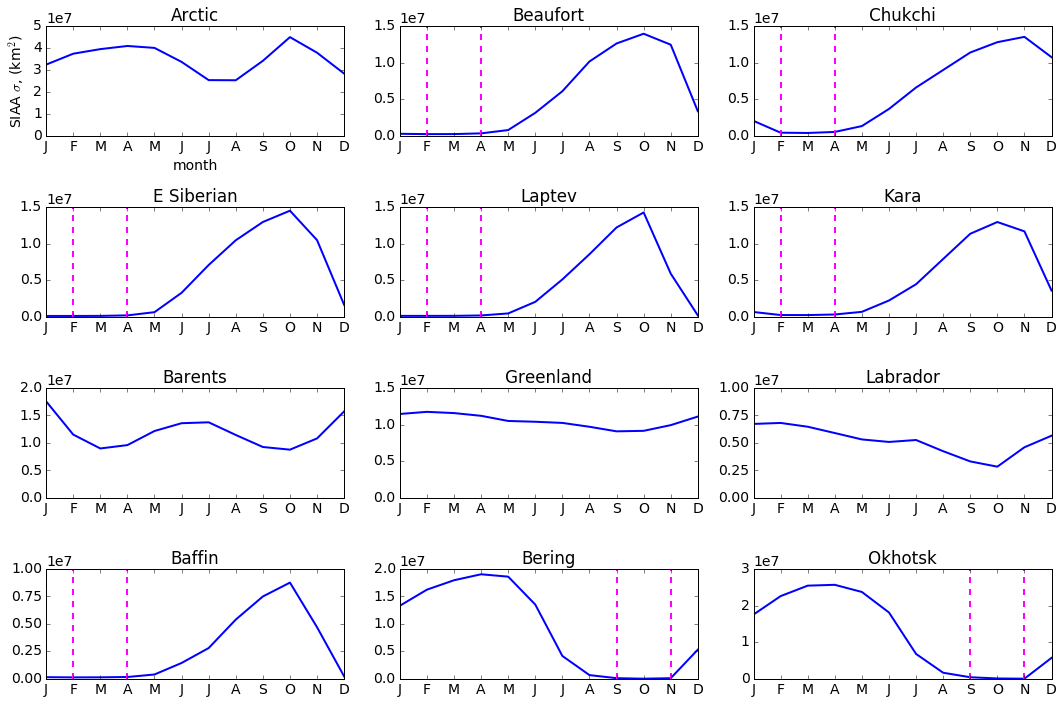

In [34]:
""" Figure 2 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

# mask out small variances
pred_panel_shift_1_stdTM = compData['pred_panel_shift_1_stdIM']
pred_panel_shift_2_stdTM = compData['pred_panel_shift_2_stdIM']
pred_panel_shift_3_stdTM = compData['pred_panel_shift_3_stdIM']
pred_panel_shift_4_stdTM = compData['pred_panel_shift_4_stdIM']
pred_panel_shift_5_stdTM = compData['pred_panel_shift_5_stdIM']
pred_panel_shift_6_stdTM = compData['pred_panel_shift_6_stdIM']
pred_panel_shift_7_stdTM = compData['pred_panel_shift_7_stdIM']
pred_panel_shift_8_stdTM = compData['pred_panel_shift_8_stdIM']
pred_panel_shift_9_stdTM = compData['pred_panel_shift_9_stdIM']
pred_panel_shift_10_stdTM = compData['pred_panel_shift_10_stdIM']
pred_panel_shift_11_stdTM = compData['pred_panel_shift_11_stdIM']
pred_panel_shift_12_stdTM = compData['pred_panel_shift_12_stdIM']
pred_panel_shift_13_stdTM = compData['pred_panel_shift_13_stdIM']
pred_panel_shift_14_stdTM = compData['pred_panel_shift_14_stdIM']
pred_panel_shift_15_stdTM = compData['pred_panel_shift_15_stdIM']
pred_panel_shift_16_stdTM = compData['pred_panel_shift_16_stdIM']

# shift to target
tmp1 = np.zeros(np.shape(pred_panel_shift_1_stdTM))
tmp2 = np.zeros(np.shape(pred_panel_shift_2_stdTM))
tmp3 = np.zeros(np.shape(pred_panel_shift_3_stdTM))
tmp4 = np.zeros(np.shape(pred_panel_shift_4_stdTM))
tmp5 = np.zeros(np.shape(pred_panel_shift_5_stdTM))
tmp6 = np.zeros(np.shape(pred_panel_shift_6_stdTM))
tmp7 = np.zeros(np.shape(pred_panel_shift_7_stdTM))
tmp8 = np.zeros(np.shape(pred_panel_shift_8_stdTM))
tmp9 = np.zeros(np.shape(pred_panel_shift_9_stdTM))
tmp10 = np.zeros(np.shape(pred_panel_shift_10_stdTM))
tmp11 = np.zeros(np.shape(pred_panel_shift_11_stdTM))
tmp12 = np.zeros(np.shape(pred_panel_shift_12_stdTM))
tmp13 = np.zeros(np.shape(pred_panel_shift_13_stdTM))
tmp14 = np.zeros(np.shape(pred_panel_shift_14_stdTM))
tmp15 = np.zeros(np.shape(pred_panel_shift_15_stdTM))
tmp16 = np.zeros(np.shape(pred_panel_shift_16_stdTM))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM, j] = pred_panel_shift_1_stdTM[i, j]
        tmp2[newM, j] = pred_panel_shift_2_stdTM[i, j]
        tmp3[newM, j] = pred_panel_shift_3_stdTM[i, j]
        tmp4[newM, j] = pred_panel_shift_4_stdTM[i, j]
        tmp5[newM, j] = pred_panel_shift_5_stdTM[i, j]
        tmp6[newM, j] = pred_panel_shift_6_stdTM[i, j]
        tmp7[newM, j] = pred_panel_shift_7_stdTM[i, j]
        tmp8[newM, j] = pred_panel_shift_8_stdTM[i, j]
        tmp9[newM, j] = pred_panel_shift_9_stdTM[i, j]
        tmp10[newM, j] = pred_panel_shift_10_stdTM[i, j]
        tmp11[newM, j] = pred_panel_shift_11_stdTM[i, j]
        tmp12[newM, j] = pred_panel_shift_12_stdTM[i, j]
        tmp13[newM, j] = pred_panel_shift_13_stdTM[i, j]
        tmp14[newM, j] = pred_panel_shift_14_stdTM[i, j]
        tmp15[newM, j] = pred_panel_shift_15_stdTM[i, j]
        tmp16[newM, j] = pred_panel_shift_16_stdTM[i, j]
pred_panel_shift_1_stdTM = tmp1
pred_panel_shift_2_stdTM = tmp2
pred_panel_shift_3_stdTM = tmp3
pred_panel_shift_4_stdTM = tmp4
pred_panel_shift_5_stdTM = tmp5
pred_panel_shift_6_stdTM = tmp6
pred_panel_shift_7_stdTM = tmp7
pred_panel_shift_8_stdTM = tmp8
pred_panel_shift_9_stdTM = tmp9
pred_panel_shift_10_stdTM = tmp10
pred_panel_shift_11_stdTM = tmp11
pred_panel_shift_12_stdTM = tmp12
pred_panel_shift_13_stdTM = tmp13
pred_panel_shift_14_stdTM = tmp14
pred_panel_shift_15_stdTM = tmp15
pred_panel_shift_16_stdTM = tmp16

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

# xLabels = ['Jan', 'Apr', 'Jul', 'Oct', 'Dec']
xLabels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
xx = range(12)

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.plot(xx, pred_panel_shift_1_stdTM[:, 0], 'b', label='KAF')
plt.ylabel(r'SIAA $\sigma$, (km$^2$)')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.xlabel('month')
plt.ylim(0, 5.0e7)
plt.yticks([0, 1e7, 2e7, 3e7, 4e7, 5e7])
plt.title('Arctic')

plt.subplot(4, 3, 2)
plt.plot(xx, pred_panel_shift_4_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1.5e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7])
plt.axvline(x=1, color='magenta', linestyle='--')
plt.axvline(x=3, color='magenta', linestyle='--')
plt.title('Beaufort')

plt.subplot(4, 3, 3)
plt.plot(xx, pred_panel_shift_3_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1.5e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7])
plt.axvline(x=1, color='magenta', linestyle='--')
plt.axvline(x=3, color='magenta', linestyle='--')
plt.title('Chukchi')

plt.subplot(4, 3, 4)
plt.plot(xx, pred_panel_shift_6_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1.5e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7])
plt.axvline(x=1, color='magenta', linestyle='--')
plt.axvline(x=3, color='magenta', linestyle='--')
plt.title('E Siberian')

plt.subplot(4, 3, 5)
plt.plot(xx, pred_panel_shift_7_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1.5e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7])
plt.axvline(x=1, color='magenta', linestyle='--')
plt.axvline(x=3, color='magenta', linestyle='--')
plt.title('Laptev')

plt.subplot(4, 3, 6)
plt.plot(xx, pred_panel_shift_10_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1.5e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7])
plt.axvline(x=1, color='magenta', linestyle='--')
plt.axvline(x=3, color='magenta', linestyle='--')
plt.title('Kara')

plt.subplot(4, 3, 7)
plt.plot(xx, pred_panel_shift_9_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 2.0e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7, 2e7])
plt.title('Barents')

plt.subplot(4, 3, 8)
plt.plot(xx, pred_panel_shift_11_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1.5e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7])
plt.title('Greenland')

plt.subplot(4, 3, 9)
plt.plot(xx, pred_panel_shift_13_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1e7)
plt.yticks([0, 0.25e7, 0.5e7, 0.75e7, 1e7])
plt.title('Labrador')

plt.subplot(4, 3, 10)
plt.plot(xx, pred_panel_shift_12_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 1e7)
plt.yticks([0, 0.25e7, 0.5e7, 0.75e7, 1e7])
plt.axvline(x=1, color='magenta', linestyle='--')
plt.axvline(x=3, color='magenta', linestyle='--')
plt.title('Baffin')

plt.subplot(4, 3, 11)
plt.plot(xx, pred_panel_shift_15_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 2e7)
plt.yticks([0, 0.5e7, 1e7, 1.5e7, 2e7])
plt.axvline(x=8, color='magenta', linestyle='--')
plt.axvline(x=10, color='magenta', linestyle='--')
plt.title('Bering')

plt.subplot(4, 3, 12)
plt.plot(xx, pred_panel_shift_16_stdTM[:, 0], 'b', label='KAF')
plt.xticks(range(12), xLabels)
plt.xlim(0, 11)
plt.ylim(0, 3e7)
plt.yticks([0, 1e7, 2e7, 3e7])
plt.axvline(x=8, color='magenta', linestyle='--')
plt.axvline(x=10, color='magenta', linestyle='--')
plt.title('Okhotsk')

fig.set_figheight(10)
fig.set_figwidth(15)
plt.tight_layout()
# plt.savefig(SAVE_DIR + iceVar + '_std.eps', format='eps', dpi=500)
plt.savefig(SAVE_DIR + 'Fig2.eps', format='eps', dpi=500)

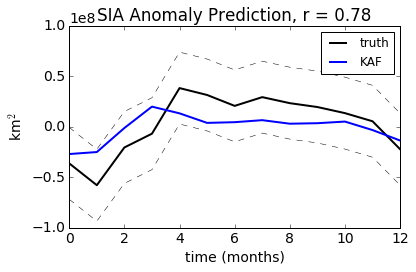

In [22]:
""" Figure 3 """
embedWin = 12
region = 'Arctic'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
truth = dataPredICA['truth']
pred_traj = dataPredICA['pred_traj']
tLagL = dataPredICA['tLag']
tLag = tLagL[0][0]

truthSTD = np.std(truth)

tt = np.linspace(0, tLag - 1, tLag)
thresh = np.ones(tLag) * 0.5

ts = 150
# ts = 160

x = truth[ts, :]
y = pred_traj[ts, :]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': True})
# plt.rcParams.update({'font.family': 'serif'})
plt.figure()
plt.plot(tt, x, 'k', linewidth=2, label='truth')
plt.plot(tt, x + truthSTD, 'k--', linewidth=0.5)
plt.plot(tt, x - truthSTD, 'k--', linewidth=0.5)
plt.plot(tt, y, linewidth=2, label='KAF')
plt.xlim(0, tLag - 1)
plt.xlabel('time (months)')
plt.yticks((-10e7, -5e7, 0, 5e7, 10e7))
plt.ylim(-10e7, 10e7)
plt.ylabel(r'km$^2$')
# plt.title('Sea Ice Area Anomaly Prediction')
plt.title('SIAA Prediction, r = %.2f' % (r_value))
plt.legend(loc='upper right', prop={'size': 12})
plt.savefig(SAVE_DIR + 'Fig3.eps', format='eps', dpi=1200)

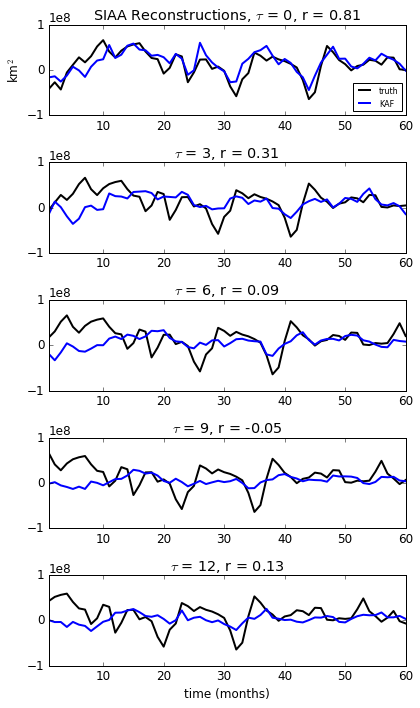

In [23]:
""" Figure 4 """
embedWin = 12
region = 'Arctic'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
data_testF = dataPredICA['data_test']  # 4785
pred_trajF = dataPredICA['pred_traj']  # 4773 x 13

ts = 120
# ts = 150

data_test = data_testF[ts:]
pred_traj = pred_trajF[ts:, :]

pLength = 60
tP = np.linspace(1, pLength, pLength)

lag = [0, 3, 6, 9, 12]

plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

x = np.squeeze(data_test[lag[0]:pLength + lag[0]])
y = pred_traj[:pLength, lag[0]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig = plt.figure()
plt.subplot(5, 1, 1)
plt.plot(tP, x, 'k', label='truth')
plt.plot(tP, y, 'b', label='KAF')
plt.legend(loc='lower right', prop={'size': 8})
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
# plt.ylabel(r'$\tau$ = ' + str(lag[0]))
plt.ylabel(r'km$^2$')
plt.title('SIAA Reconstructions, ' + r'$\tau$ = ' + str(lag[0]) + ', r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[1]:pLength + lag[1]])
y = pred_traj[:pLength, lag[1]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 2)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
# plt.ylabel(r'$\tau$ = ' + str(lag[1]))
plt.title(r'$\tau$ = ' + str(lag[1]) + ', r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[2]:pLength + lag[2]])
y = pred_traj[:pLength, lag[2]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 3)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
# plt.ylabel(r'$\tau$ = ' + str(lag[2]))
plt.title(r'$\tau$ = ' + str(lag[2]) + ', r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[3]:pLength + lag[3]])
y = pred_traj[:pLength, lag[3]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 4)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
# plt.ylabel(r'$\tau$ = ' + str(lag[3]))
plt.title('r = %.2f' % (r_value))
plt.title(r'$\tau$ = ' + str(lag[3]) + ', r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[4]:pLength + lag[4]])
y = pred_traj[:pLength, lag[4]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 5)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
# plt.ylabel(r'$\tau$ = ' + str(lag[4]))
plt.xlabel('time (months)')
plt.title(r'$\tau$ = ' + str(lag[4]) + ', r = %.2f' % (r_value))
# plt.tight_layout()
fig.set_figheight(10)
plt.savefig(SAVE_DIR + 'Fig4.eps', format='eps', dpi=1000)

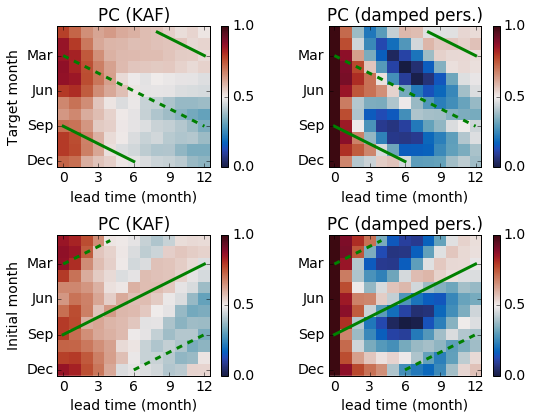

In [24]:
""" Figure 5 """
embedWin = 12
region = 'Arctic'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')

pred_pcTM = dataPredICA['pred_pcIM']
pred_pcIM = dataPredICA['pred_pcIM']
if dampedP == 1:
    pred_pcTMP = dataPredICA['pred_pcIMDP']
    pred_pcIMP = dataPredICA['pred_pcIMDP']    
else:
    pred_pcTMP = dataPredICA['pred_pcIMP']
    pred_pcIMP = dataPredICA['pred_pcIMP']    
std_truthTM = dataPredICA['std_truthTM']

# shift due to 12 month embedding window
mM = [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp1 = np.zeros(np.shape(pred_pcTM))
tmp2 = np.zeros(np.shape(pred_pcTM))
tmp3 = np.zeros(np.shape(pred_pcTM))
tmp1 = pred_pcTM[mM, :]
tmp2 = pred_pcTMP[mM, :]
tmp3 = std_truthTM[mM, :]
pred_pcTM = tmp1
pred_pcTMP = tmp2
std_truthTM = tmp3

# shift to target
tmp1 = np.zeros(np.shape(pred_pcTM))
tmp2 = np.zeros(np.shape(pred_pcTM))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_pcTM[i,j]
        tmp2[newM,j] = pred_pcTMP[i,j]
pred_pcTM = tmp1
pred_pcTMP = tmp2

# mask out small variances
pred_pcTM[std_truthTM < std_thresh] = np.nan
pred_pcTMP[std_truthTM < std_thresh] = np.nan

cTicks = np.linspace(0, 1, 3)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': False})
# plt.rcParams.update({'font.family': 'serif'})

fig = plt.figure()
plt.subplot(221)
plt.imshow(pred_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('PC (KAF)')
plt.plot([2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8], color='green', linestyle='--', linewidth=3)
plt.plot([8, 8.5, 9, 9.5, 10, 10.5, 11], color='green', linewidth=3)
plt.plot([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
          np.nan, 0, 0.5, 1, 1.5, 2], color='green', linewidth=3)
plt.colorbar().set_ticks(cTicks)
plt.subplot(222)
plt.imshow(pred_pcTMP,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('PC (damped pers.)')
plt.plot([2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8], color='green', linestyle='--', linewidth=3)
plt.plot([8, 8.5, 9, 9.5, 10, 10.5, 11], color='green', linewidth=3)
plt.plot([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
          np.nan, 0, 0.5, 1, 1.5, 2], color='green', linewidth=3)

plt.colorbar().set_ticks(cTicks)
plt.subplot(223)
plt.imshow(pred_pcIM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Initial month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('PC (KAF)')
plt.plot([2, 1.5, 1, 0.5, 0], color='green', linestyle='--', linewidth=3)
plt.plot([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
          11, 10.5, 10, 9.5, 9, 8.5, 8], color='green', linestyle='--', linewidth=3)
plt.plot([8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2], color='green', linewidth=3)
plt.colorbar().set_ticks(cTicks)
plt.subplot(224)
plt.imshow(pred_pcIMP,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('PC (damped pers.)')
plt.plot([2, 1.5, 1, 0.5, 0], color='green', linestyle='--', linewidth=3)
plt.plot([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
          11, 10.5, 10, 9.5, 9, 8.5, 8], color='green', linestyle='--', linewidth=3)
plt.plot([8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2], color='green', linewidth=3)
plt.colorbar().set_ticks(cTicks)

# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# # cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# # cax = plt.axes([0.85, 0.1, 0.075, 0.5])
# cax = plt.axes([0.85, 0.21, 0.04, 0.57])
# plt.colorbar(cax=cax, ticks=cTicks)

fig.set_figwidth(8)
fig.set_figheight(6)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig5.eps', format='eps', dpi=1200)

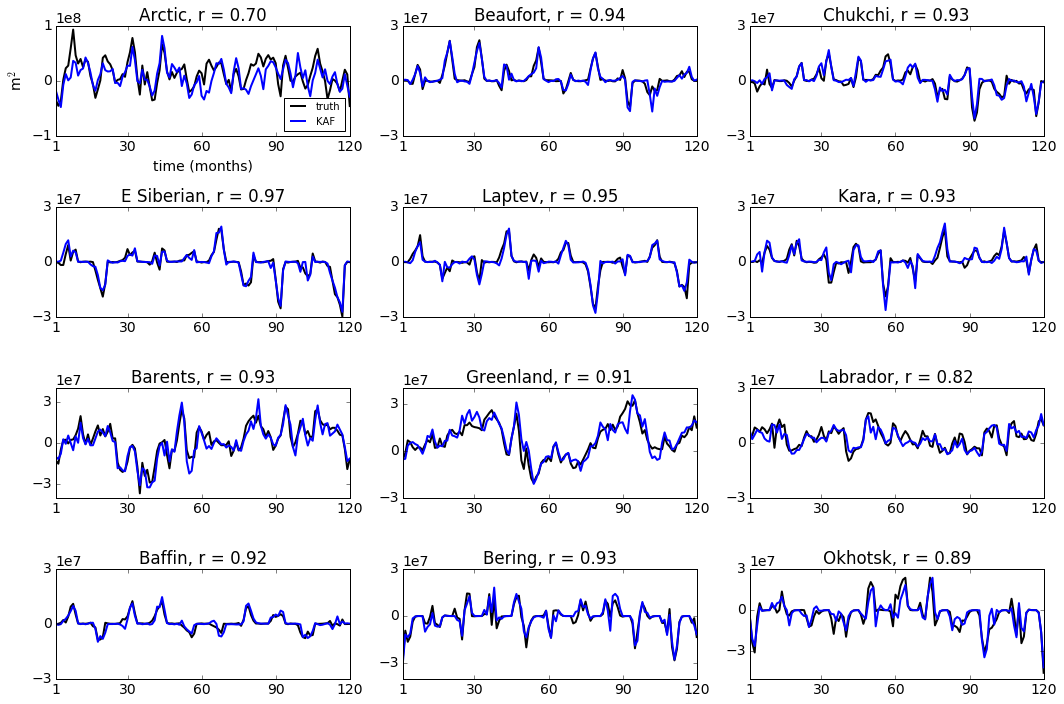

In [25]:
""" Figure 6 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

pred_panel_1_truth = compData['pred_panel_1_truth']
pred_panel_2_truth = compData['pred_panel_2_truth']
pred_panel_3_truth = compData['pred_panel_3_truth']
pred_panel_4_truth = compData['pred_panel_4_truth']
pred_panel_5_truth = compData['pred_panel_5_truth']
pred_panel_6_truth = compData['pred_panel_6_truth']
pred_panel_7_truth = compData['pred_panel_7_truth']
pred_panel_8_truth = compData['pred_panel_8_truth']
pred_panel_9_truth = compData['pred_panel_9_truth']
pred_panel_10_truth = compData['pred_panel_10_truth']
pred_panel_11_truth = compData['pred_panel_11_truth']
pred_panel_12_truth = compData['pred_panel_12_truth']
pred_panel_13_truth = compData['pred_panel_13_truth']
pred_panel_14_truth = compData['pred_panel_14_truth']
pred_panel_15_truth = compData['pred_panel_15_truth']
pred_panel_16_truth = compData['pred_panel_16_truth']

pred_panel_1_ose = compData['pred_panel_1_ose']
pred_panel_2_ose = compData['pred_panel_2_ose']
pred_panel_3_ose = compData['pred_panel_3_ose']
pred_panel_4_ose = compData['pred_panel_4_ose']
pred_panel_5_ose = compData['pred_panel_5_ose']
pred_panel_6_ose = compData['pred_panel_6_ose']
pred_panel_7_ose = compData['pred_panel_7_ose']
pred_panel_8_ose = compData['pred_panel_8_ose']
pred_panel_9_ose = compData['pred_panel_9_ose']
pred_panel_10_ose = compData['pred_panel_10_ose']
pred_panel_11_ose = compData['pred_panel_11_ose']
pred_panel_12_ose = compData['pred_panel_12_ose']
pred_panel_13_ose = compData['pred_panel_13_ose']
pred_panel_14_ose = compData['pred_panel_14_ose']
pred_panel_15_ose = compData['pred_panel_15_ose']
pred_panel_16_ose = compData['pred_panel_16_ose']

tR = 120
tt = np.linspace(1, tR, tR)

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()

x = np.squeeze(pred_panel_1_truth[:tR])
y = np.squeeze(pred_panel_1_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 1)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Arctic, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.xlabel('time (months)')
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'm$^2$')
plt.legend(loc='lower right', prop={'size': 10})
plt.legend(loc='lower right', prop={'size': 10})

x = np.squeeze(pred_panel_4_truth[:tR])
y = np.squeeze(pred_panel_4_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 2)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Beaufort, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_3_truth[:tR])
y = np.squeeze(pred_panel_3_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 3)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Chukchi, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_6_truth[:tR])
y = np.squeeze(pred_panel_6_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 4)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('E Siberian, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_7_truth[:tR])
y = np.squeeze(pred_panel_7_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 5)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Laptev, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_10_truth[:tR])
y = np.squeeze(pred_panel_10_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 6)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Kara, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_9_truth[:tR])
y = np.squeeze(pred_panel_9_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 7)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Barents, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_11_truth[:tR])
y = np.squeeze(pred_panel_11_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 8)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Greenland, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_13_truth[:tR])
y = np.squeeze(pred_panel_13_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 9)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Labrador, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_12_truth[:tR])
y = np.squeeze(pred_panel_12_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 10)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Baffin, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_15_truth[:tR])
y = np.squeeze(pred_panel_15_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 11)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Bering, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_16_truth[:tR])
y = np.squeeze(pred_panel_16_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 12)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Okhotsk, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig(SAVE_DIR + 'Fig6.eps', format='eps', dpi=1200)

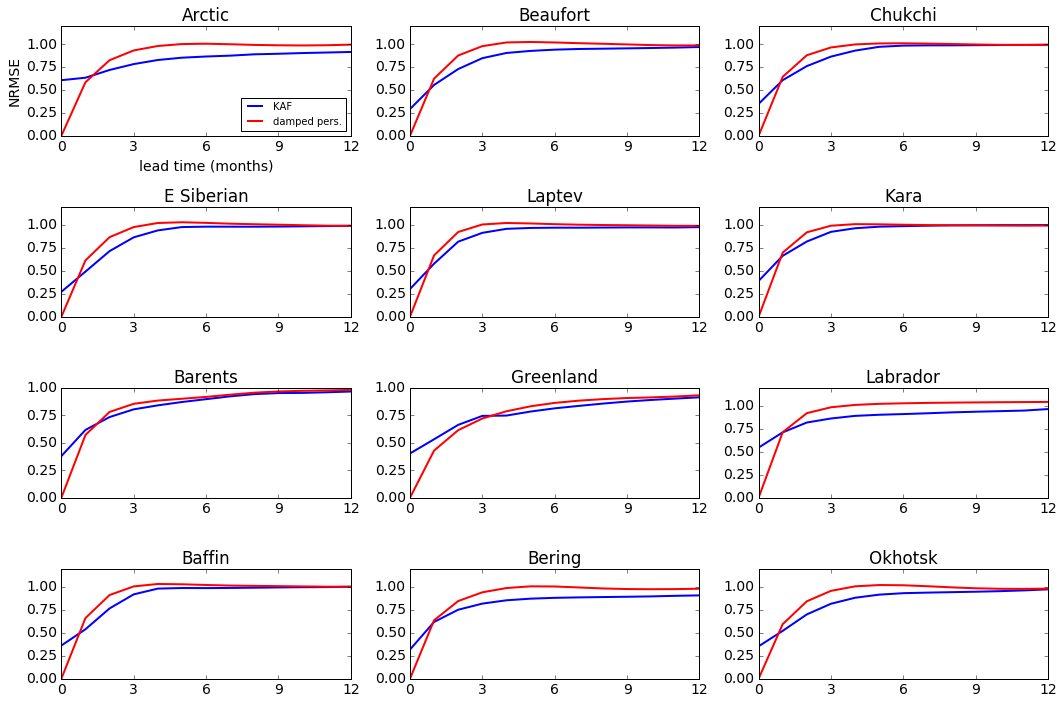

In [30]:
""" Figure 7 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_1_rms = np.squeeze(compData['pred_panel_1_rms'])
pred_panel_2_rms = np.squeeze(compData['pred_panel_2_rms'])
pred_panel_3_rms = np.squeeze(compData['pred_panel_3_rms'])
pred_panel_4_rms = np.squeeze(compData['pred_panel_4_rms'])
pred_panel_5_rms = np.squeeze(compData['pred_panel_5_rms'])
pred_panel_6_rms = np.squeeze(compData['pred_panel_6_rms'])
pred_panel_7_rms = np.squeeze(compData['pred_panel_7_rms'])
pred_panel_8_rms = np.squeeze(compData['pred_panel_8_rms'])
pred_panel_9_rms = np.squeeze(compData['pred_panel_9_rms'])
pred_panel_10_rms = np.squeeze(compData['pred_panel_10_rms'])
pred_panel_11_rms = np.squeeze(compData['pred_panel_11_rms'])
pred_panel_12_rms = np.squeeze(compData['pred_panel_12_rms'])
pred_panel_13_rms = np.squeeze(compData['pred_panel_13_rms'])
pred_panel_14_rms = np.squeeze(compData['pred_panel_14_rms'])
pred_panel_15_rms = np.squeeze(compData['pred_panel_15_rms'])
pred_panel_16_rms = np.squeeze(compData['pred_panel_16_rms'])

if dampedP == 1:
    pred_panel_1_rmsP = np.squeeze(compData['pred_panel_1_rmsDP'])
    pred_panel_2_rmsP = np.squeeze(compData['pred_panel_2_rmsDP'])
    pred_panel_3_rmsP = np.squeeze(compData['pred_panel_3_rmsDP'])
    pred_panel_4_rmsP = np.squeeze(compData['pred_panel_4_rmsDP'])
    pred_panel_5_rmsP = np.squeeze(compData['pred_panel_5_rmsDP'])
    pred_panel_6_rmsP = np.squeeze(compData['pred_panel_6_rmsDP'])
    pred_panel_7_rmsP = np.squeeze(compData['pred_panel_7_rmsDP'])
    pred_panel_8_rmsP = np.squeeze(compData['pred_panel_8_rmsDP'])
    pred_panel_9_rmsP = np.squeeze(compData['pred_panel_9_rmsDP'])
    pred_panel_10_rmsP = np.squeeze(compData['pred_panel_10_rmsDP'])
    pred_panel_11_rmsP = np.squeeze(compData['pred_panel_11_rmsDP'])
    pred_panel_12_rmsP = np.squeeze(compData['pred_panel_12_rmsDP'])
    pred_panel_13_rmsP = np.squeeze(compData['pred_panel_13_rmsDP'])
    pred_panel_14_rmsP = np.squeeze(compData['pred_panel_14_rmsDP'])
    pred_panel_15_rmsP = np.squeeze(compData['pred_panel_15_rmsDP'])
    pred_panel_16_rmsP = np.squeeze(compData['pred_panel_16_rmsDP'])
else:
    pred_panel_1_rmsP = np.squeeze(compData['pred_panel_1_rmsP'])
    pred_panel_2_rmsP = np.squeeze(compData['pred_panel_2_rmsP'])
    pred_panel_3_rmsP = np.squeeze(compData['pred_panel_3_rmsP'])
    pred_panel_4_rmsP = np.squeeze(compData['pred_panel_4_rmsP'])
    pred_panel_5_rmsP = np.squeeze(compData['pred_panel_5_rmsP'])
    pred_panel_6_rmsP = np.squeeze(compData['pred_panel_6_rmsP'])
    pred_panel_7_rmsP = np.squeeze(compData['pred_panel_7_rmsP'])
    pred_panel_8_rmsP = np.squeeze(compData['pred_panel_8_rmsP'])
    pred_panel_9_rmsP = np.squeeze(compData['pred_panel_9_rmsP'])
    pred_panel_10_rmsP = np.squeeze(compData['pred_panel_10_rmsP'])
    pred_panel_11_rmsP = np.squeeze(compData['pred_panel_11_rmsP'])
    pred_panel_12_rmsP = np.squeeze(compData['pred_panel_12_rmsP'])
    pred_panel_13_rmsP = np.squeeze(compData['pred_panel_13_rmsP'])
    pred_panel_14_rmsP = np.squeeze(compData['pred_panel_14_rmsP'])
    pred_panel_15_rmsP = np.squeeze(compData['pred_panel_15_rmsP'])
    pred_panel_16_rmsP = np.squeeze(compData['pred_panel_16_rmsP'])

tt = np.linspace(0, int(tLag) - 1, int(tLag))

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.plot(tt, pred_panel_1_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_1_rmsP, 'r', label='damped pers.')
plt.title('Arctic')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.xlabel('lead time (months)')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)
# plt.ylabel(r'RMSE (km$^2$)')
plt.ylabel('NRMSE')
plt.legend(loc='lower right', prop={'size': 10})

plt.subplot(4, 3, 2)
plt.plot(tt, pred_panel_4_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_4_rmsP, 'r', label='damped pers.')
plt.title('Beaufort')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 3)
plt.plot(tt, pred_panel_3_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_3_rmsP, 'r', label='damped pers.')
plt.title('Chukchi')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 4)
plt.plot(tt, pred_panel_6_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_6_rmsP, 'r', label='damped pers.')
plt.title('E Siberian')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 5)
plt.plot(tt, pred_panel_7_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_7_rmsP, 'r', label='damped pers.')
plt.title('Laptev')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 6)
plt.plot(tt, pred_panel_10_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_10_rmsP, 'r', label='damped pers.')
plt.title('Kara')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 7)
plt.plot(tt, pred_panel_9_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_9_rmsP, 'r', label='damped pers.')
plt.title('Barents')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 8)
plt.plot(tt, pred_panel_11_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_11_rmsP, 'r', label='damped pers.')
plt.title('Greenland')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 9)
plt.plot(tt, pred_panel_13_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_13_rmsP, 'r', label='damped pers.')
plt.title('Labrador')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 10)
plt.plot(tt, pred_panel_12_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_12_rmsP, 'r', label='damped pers.')
plt.title('Baffin')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 11)
plt.plot(tt, pred_panel_15_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_15_rmsP, 'r', label='damped pers.')
plt.title('Bering')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

plt.subplot(4, 3, 12)
plt.plot(tt, pred_panel_16_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_16_rmsP, 'r', label='damped pers.')
plt.title('Okhotsk')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylim(0,1)

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig(SAVE_DIR + 'Fig7.eps', format='eps', dpi=1200)

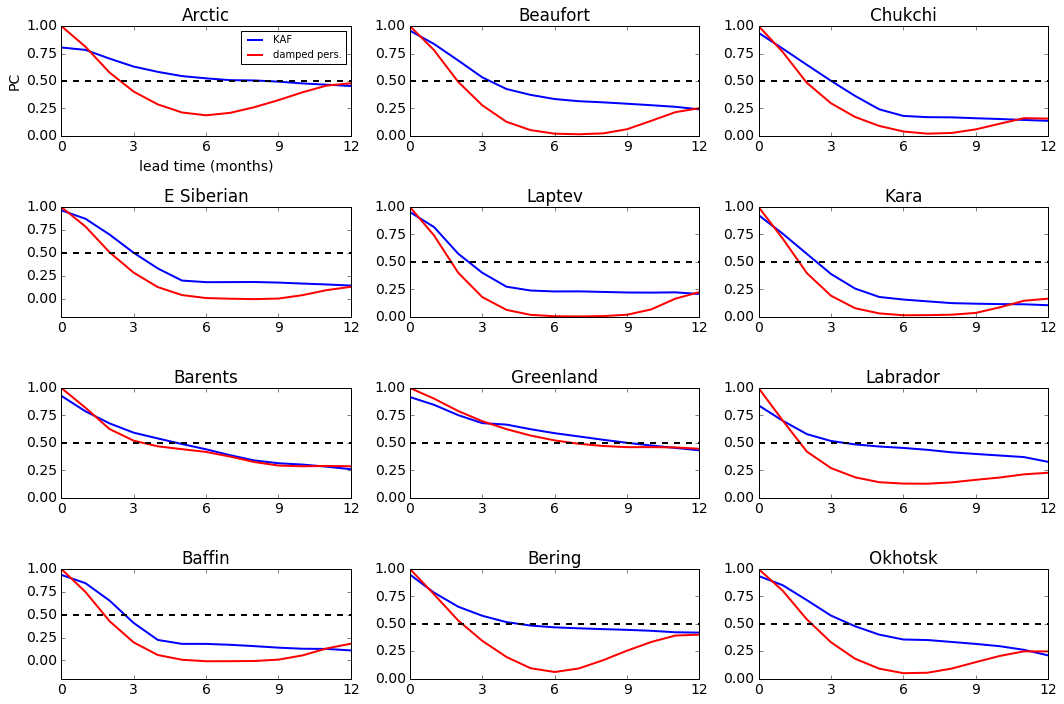

In [31]:
""" Figure 8 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_1_pc = np.squeeze(compData['pred_panel_1_pc'])
pred_panel_2_pc = np.squeeze(compData['pred_panel_2_pc'])
pred_panel_3_pc = np.squeeze(compData['pred_panel_3_pc'])
pred_panel_4_pc = np.squeeze(compData['pred_panel_4_pc'])
pred_panel_5_pc = np.squeeze(compData['pred_panel_5_pc'])
pred_panel_6_pc = np.squeeze(compData['pred_panel_6_pc'])
pred_panel_7_pc = np.squeeze(compData['pred_panel_7_pc'])
pred_panel_8_pc = np.squeeze(compData['pred_panel_8_pc'])
pred_panel_9_pc = np.squeeze(compData['pred_panel_9_pc'])
pred_panel_10_pc = np.squeeze(compData['pred_panel_10_pc'])
pred_panel_11_pc = np.squeeze(compData['pred_panel_11_pc'])
pred_panel_12_pc = np.squeeze(compData['pred_panel_12_pc'])
pred_panel_13_pc = np.squeeze(compData['pred_panel_13_pc'])
pred_panel_14_pc = np.squeeze(compData['pred_panel_14_pc'])
pred_panel_15_pc = np.squeeze(compData['pred_panel_15_pc'])
pred_panel_16_pc = np.squeeze(compData['pred_panel_16_pc'])

if dampedP == 1:
    pred_panel_1_pcP = np.squeeze(compData['pred_panel_1_pcDP'])
    pred_panel_2_pcP = np.squeeze(compData['pred_panel_2_pcDP'])
    pred_panel_3_pcP = np.squeeze(compData['pred_panel_3_pcDP'])
    pred_panel_4_pcP = np.squeeze(compData['pred_panel_4_pcDP'])
    pred_panel_5_pcP = np.squeeze(compData['pred_panel_5_pcDP'])
    pred_panel_6_pcP = np.squeeze(compData['pred_panel_6_pcDP'])
    pred_panel_7_pcP = np.squeeze(compData['pred_panel_7_pcDP'])
    pred_panel_8_pcP = np.squeeze(compData['pred_panel_8_pcDP'])
    pred_panel_9_pcP = np.squeeze(compData['pred_panel_9_pcDP'])
    pred_panel_10_pcP = np.squeeze(compData['pred_panel_10_pcDP'])
    pred_panel_11_pcP = np.squeeze(compData['pred_panel_11_pcDP'])
    pred_panel_12_pcP = np.squeeze(compData['pred_panel_12_pcDP'])
    pred_panel_13_pcP = np.squeeze(compData['pred_panel_13_pcDP'])
    pred_panel_14_pcP = np.squeeze(compData['pred_panel_14_pcDP'])
    pred_panel_15_pcP = np.squeeze(compData['pred_panel_15_pcDP'])
    pred_panel_16_pcP = np.squeeze(compData['pred_panel_16_pcDP'])
else:
    pred_panel_1_pcP = np.squeeze(compData['pred_panel_1_pcP'])
    pred_panel_2_pcP = np.squeeze(compData['pred_panel_2_pcP'])
    pred_panel_3_pcP = np.squeeze(compData['pred_panel_3_pcP'])
    pred_panel_4_pcP = np.squeeze(compData['pred_panel_4_pcP'])
    pred_panel_5_pcP = np.squeeze(compData['pred_panel_5_pcP'])
    pred_panel_6_pcP = np.squeeze(compData['pred_panel_6_pcP'])
    pred_panel_7_pcP = np.squeeze(compData['pred_panel_7_pcP'])
    pred_panel_8_pcP = np.squeeze(compData['pred_panel_8_pcP'])
    pred_panel_9_pcP = np.squeeze(compData['pred_panel_9_pcP'])
    pred_panel_10_pcP = np.squeeze(compData['pred_panel_10_pcP'])
    pred_panel_11_pcP = np.squeeze(compData['pred_panel_11_pcP'])
    pred_panel_12_pcP = np.squeeze(compData['pred_panel_12_pcP'])
    pred_panel_13_pcP = np.squeeze(compData['pred_panel_13_pcP'])
    pred_panel_14_pcP = np.squeeze(compData['pred_panel_14_pcP'])
    pred_panel_15_pcP = np.squeeze(compData['pred_panel_15_pcP'])
    pred_panel_16_pcP = np.squeeze(compData['pred_panel_16_pcP'])

tt = np.linspace(0, int(tLag) - 1, int(tLag))

thresh = np.ones(tLag) * 0.5

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.plot(tt, pred_panel_1_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_1_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Arctic')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.xlabel('lead time (months)')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('PC')
plt.legend(loc='upper right', prop={'size': 10})

plt.subplot(4, 3, 2)
plt.plot(tt, pred_panel_4_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_4_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Beaufort')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 3)
plt.plot(tt, pred_panel_3_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_3_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Chukchi')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 4)
plt.plot(tt, pred_panel_6_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_6_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('E Siberian')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 5)
plt.plot(tt, pred_panel_7_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_7_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Laptev')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 6)
plt.plot(tt, pred_panel_10_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_10_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Kara')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 7)
plt.plot(tt, pred_panel_9_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_9_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Barents')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 8)
plt.plot(tt, pred_panel_11_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_11_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Greenland')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 9)
plt.plot(tt, pred_panel_13_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_13_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Labrador')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 10)
plt.plot(tt, pred_panel_12_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_12_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Baffin')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 11)
plt.plot(tt, pred_panel_15_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_15_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Bering')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 12)
plt.plot(tt, pred_panel_16_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_16_pcP, 'r', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Okhotsk')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig(SAVE_DIR + 'Fig8.eps', format='eps', dpi=1200)

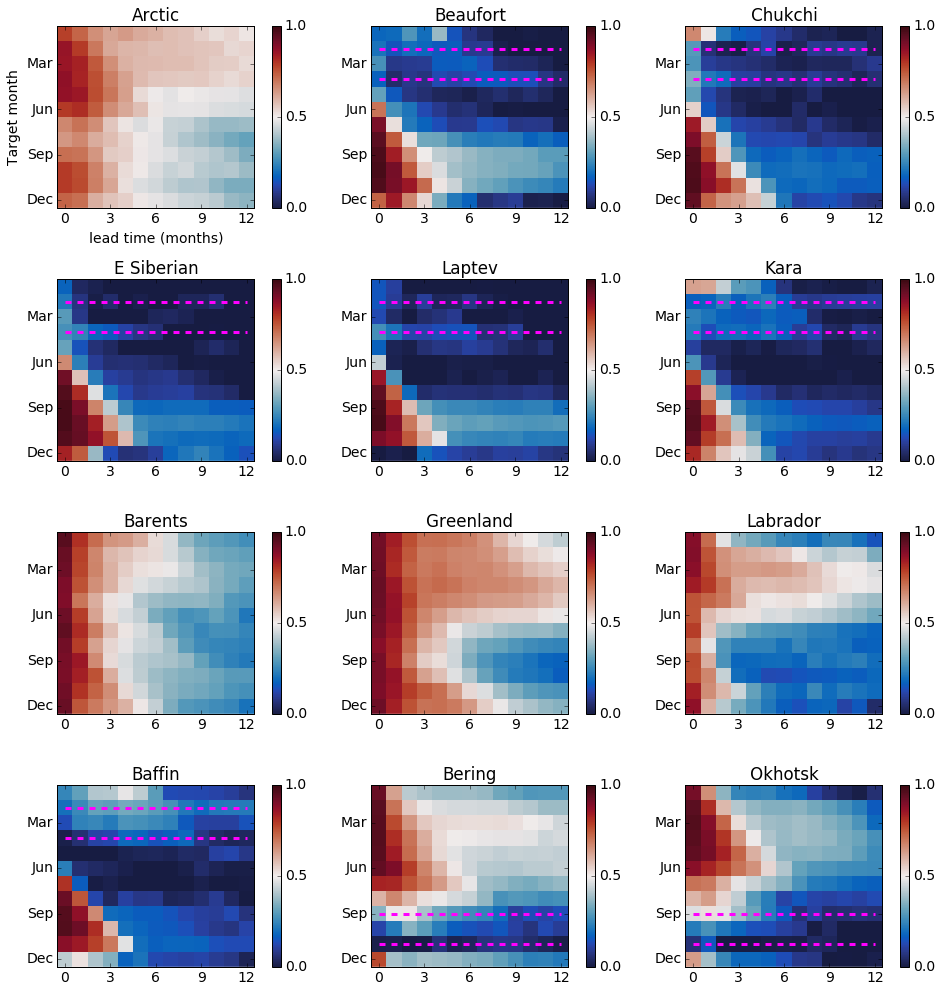

In [29]:
""" Figure 9 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_shift_1_pcTM = compData['pred_panel_shift_1_pcIM']
pred_panel_shift_2_pcTM = compData['pred_panel_shift_2_pcIM']
pred_panel_shift_3_pcTM = compData['pred_panel_shift_3_pcIM']
pred_panel_shift_4_pcTM = compData['pred_panel_shift_4_pcIM']
pred_panel_shift_5_pcTM = compData['pred_panel_shift_5_pcIM']
pred_panel_shift_6_pcTM = compData['pred_panel_shift_6_pcIM']
pred_panel_shift_7_pcTM = compData['pred_panel_shift_7_pcIM']
pred_panel_shift_8_pcTM = compData['pred_panel_shift_8_pcIM']
pred_panel_shift_9_pcTM = compData['pred_panel_shift_9_pcIM']
pred_panel_shift_10_pcTM = compData['pred_panel_shift_10_pcIM']
pred_panel_shift_11_pcTM = compData['pred_panel_shift_11_pcIM']
pred_panel_shift_12_pcTM = compData['pred_panel_shift_12_pcIM']
pred_panel_shift_13_pcTM = compData['pred_panel_shift_13_pcIM']
pred_panel_shift_14_pcTM = compData['pred_panel_shift_14_pcIM']
pred_panel_shift_15_pcTM = compData['pred_panel_shift_15_pcIM']
pred_panel_shift_16_pcTM = compData['pred_panel_shift_16_pcIM']

# shift to target
tmp1 = np.zeros(np.shape(pred_panel_shift_1_pcTM))
tmp2 = np.zeros(np.shape(pred_panel_shift_2_pcTM))
tmp3 = np.zeros(np.shape(pred_panel_shift_3_pcTM))
tmp4 = np.zeros(np.shape(pred_panel_shift_4_pcTM))
tmp5 = np.zeros(np.shape(pred_panel_shift_5_pcTM))
tmp6 = np.zeros(np.shape(pred_panel_shift_6_pcTM))
tmp7 = np.zeros(np.shape(pred_panel_shift_7_pcTM))
tmp8 = np.zeros(np.shape(pred_panel_shift_8_pcTM))
tmp9 = np.zeros(np.shape(pred_panel_shift_9_pcTM))
tmp10 = np.zeros(np.shape(pred_panel_shift_10_pcTM))
tmp11 = np.zeros(np.shape(pred_panel_shift_11_pcTM))
tmp12 = np.zeros(np.shape(pred_panel_shift_12_pcTM))
tmp13 = np.zeros(np.shape(pred_panel_shift_13_pcTM))
tmp14 = np.zeros(np.shape(pred_panel_shift_14_pcTM))
tmp15 = np.zeros(np.shape(pred_panel_shift_15_pcTM))
tmp16 = np.zeros(np.shape(pred_panel_shift_16_pcTM))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_panel_shift_1_pcTM[i,j]
        tmp2[newM,j] = pred_panel_shift_2_pcTM[i,j]
        tmp3[newM,j] = pred_panel_shift_3_pcTM[i,j]
        tmp4[newM,j] = pred_panel_shift_4_pcTM[i,j]
        tmp5[newM,j] = pred_panel_shift_5_pcTM[i,j]
        tmp6[newM,j] = pred_panel_shift_6_pcTM[i,j]
        tmp7[newM,j] = pred_panel_shift_7_pcTM[i,j]
        tmp8[newM,j] = pred_panel_shift_8_pcTM[i,j] 
        tmp9[newM,j] = pred_panel_shift_9_pcTM[i,j]
        tmp10[newM,j] = pred_panel_shift_10_pcTM[i,j]
        tmp11[newM,j] = pred_panel_shift_11_pcTM[i,j]
        tmp12[newM,j] = pred_panel_shift_12_pcTM[i,j] 
        tmp13[newM,j] = pred_panel_shift_13_pcTM[i,j]
        tmp14[newM,j] = pred_panel_shift_14_pcTM[i,j]
        tmp15[newM,j] = pred_panel_shift_15_pcTM[i,j]
        tmp16[newM,j] = pred_panel_shift_16_pcTM[i,j]
pred_panel_shift_1_pcTM = tmp1
pred_panel_shift_2_pcTM = tmp2
pred_panel_shift_3_pcTM = tmp3
pred_panel_shift_4_pcTM = tmp4
pred_panel_shift_5_pcTM = tmp5
pred_panel_shift_6_pcTM = tmp6
pred_panel_shift_7_pcTM = tmp7
pred_panel_shift_8_pcTM = tmp8
pred_panel_shift_9_pcTM = tmp9
pred_panel_shift_10_pcTM = tmp10
pred_panel_shift_11_pcTM = tmp11
pred_panel_shift_12_pcTM = tmp12
pred_panel_shift_13_pcTM = tmp13
pred_panel_shift_14_pcTM = tmp14
pred_panel_shift_15_pcTM = tmp15
pred_panel_shift_16_pcTM = tmp16

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(0, 1, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig9.eps', format='eps', dpi=500)

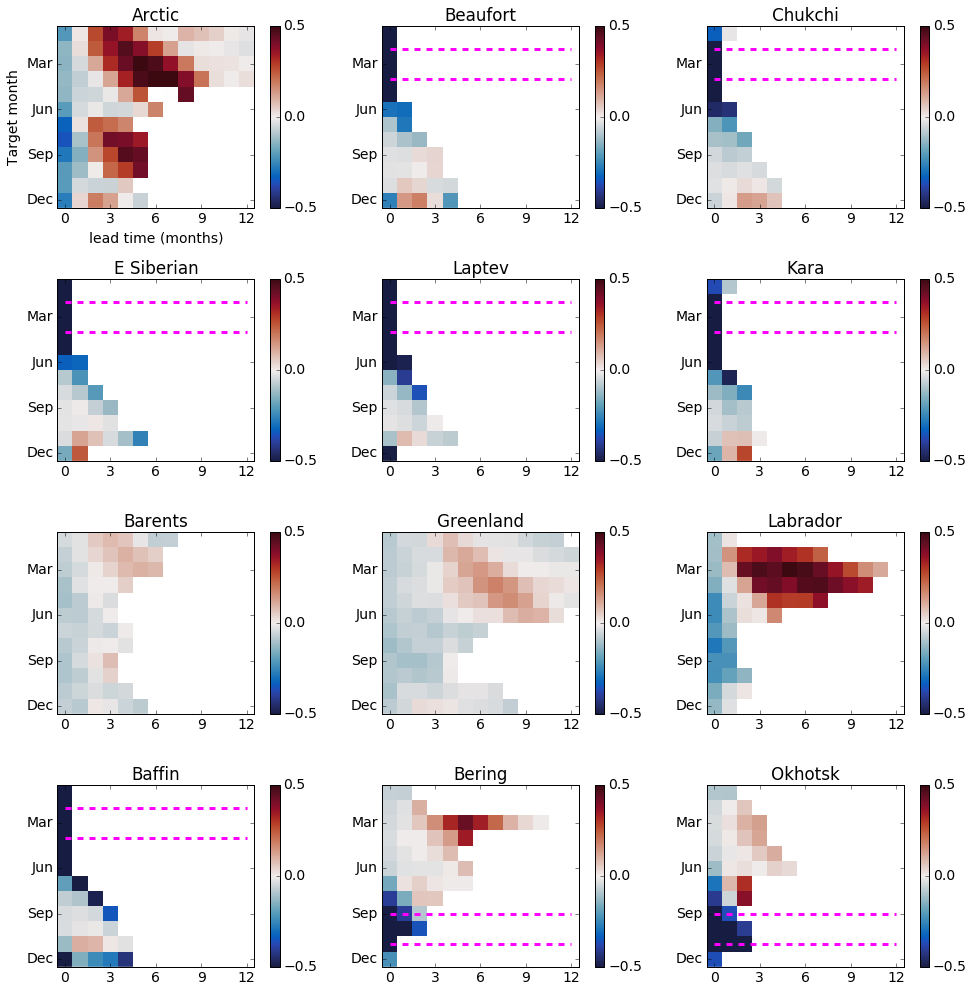

In [14]:
""" Figure 10 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'
compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')
tLag = compData['tLag']

if dampedP == 1:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcIMDdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcIMDdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcIMDdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcIMDdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcIMDdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcIMDdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcIMDdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcIMDdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcIMDdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcIMDdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcIMDdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcIMDdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcIMDdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcIMDdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcIMDdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcIMDdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcIMDdiff']
else:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcIMdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcIMdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcIMdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcIMdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcIMdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcIMdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcIMdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcIMdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcIMdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcIMdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcIMdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcIMdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcIMdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcIMdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcIMdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcIMdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcIMdiff']

# shift to target
tmp1 = np.zeros(np.shape(pred_panel_shift_1_pcTMdiff))
tmp2 = np.zeros(np.shape(pred_panel_shift_2_pcTMdiff))
tmp3 = np.zeros(np.shape(pred_panel_shift_3_pcTMdiff))
tmp4 = np.zeros(np.shape(pred_panel_shift_4_pcTMdiff))
tmp5 = np.zeros(np.shape(pred_panel_shift_5_pcTMdiff))
tmp6 = np.zeros(np.shape(pred_panel_shift_6_pcTMdiff))
tmp7 = np.zeros(np.shape(pred_panel_shift_7_pcTMdiff))
tmp8 = np.zeros(np.shape(pred_panel_shift_8_pcTMdiff))
tmp9 = np.zeros(np.shape(pred_panel_shift_9_pcTMdiff))
tmp10 = np.zeros(np.shape(pred_panel_shift_10_pcTMdiff))
tmp11 = np.zeros(np.shape(pred_panel_shift_11_pcTMdiff))
tmp12 = np.zeros(np.shape(pred_panel_shift_12_pcTMdiff))
tmp13 = np.zeros(np.shape(pred_panel_shift_13_pcTMdiff))
tmp14 = np.zeros(np.shape(pred_panel_shift_14_pcTMdiff))
tmp15 = np.zeros(np.shape(pred_panel_shift_15_pcTMdiff))
tmp16 = np.zeros(np.shape(pred_panel_shift_16_pcTMdiff))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_panel_shift_1_pcTMdiff[i,j]
        tmp2[newM,j] = pred_panel_shift_2_pcTMdiff[i,j]
        tmp3[newM,j] = pred_panel_shift_3_pcTMdiff[i,j]
        tmp4[newM,j] = pred_panel_shift_4_pcTMdiff[i,j]
        tmp5[newM,j] = pred_panel_shift_5_pcTMdiff[i,j]
        tmp6[newM,j] = pred_panel_shift_6_pcTMdiff[i,j]
        tmp7[newM,j] = pred_panel_shift_7_pcTMdiff[i,j]
        tmp8[newM,j] = pred_panel_shift_8_pcTMdiff[i,j] 
        tmp9[newM,j] = pred_panel_shift_9_pcTMdiff[i,j]
        tmp10[newM,j] = pred_panel_shift_10_pcTMdiff[i,j]
        tmp11[newM,j] = pred_panel_shift_11_pcTMdiff[i,j]
        tmp12[newM,j] = pred_panel_shift_12_pcTMdiff[i,j] 
        tmp13[newM,j] = pred_panel_shift_13_pcTMdiff[i,j]
        tmp14[newM,j] = pred_panel_shift_14_pcTMdiff[i,j]
        tmp15[newM,j] = pred_panel_shift_15_pcTMdiff[i,j]
        tmp16[newM,j] = pred_panel_shift_16_pcTMdiff[i,j]
pred_panel_shift_1_pcTMdiff = tmp1
pred_panel_shift_2_pcTMdiff = tmp2
pred_panel_shift_3_pcTMdiff = tmp3
pred_panel_shift_4_pcTMdiff = tmp4
pred_panel_shift_5_pcTMdiff = tmp5
pred_panel_shift_6_pcTMdiff = tmp6
pred_panel_shift_7_pcTMdiff = tmp7
pred_panel_shift_8_pcTMdiff = tmp8
pred_panel_shift_9_pcTMdiff = tmp9
pred_panel_shift_10_pcTMdiff = tmp10
pred_panel_shift_11_pcTMdiff = tmp11
pred_panel_shift_12_pcTMdiff = tmp12
pred_panel_shift_13_pcTMdiff = tmp13
pred_panel_shift_14_pcTMdiff = tmp14
pred_panel_shift_15_pcTMdiff = tmp15
pred_panel_shift_16_pcTMdiff = tmp16
    
plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(-0.5, 0.5, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.plot([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], color='magenta', linestyle='--', linewidth=3)
plt.plot([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig10.eps', format='eps', dpi=500)

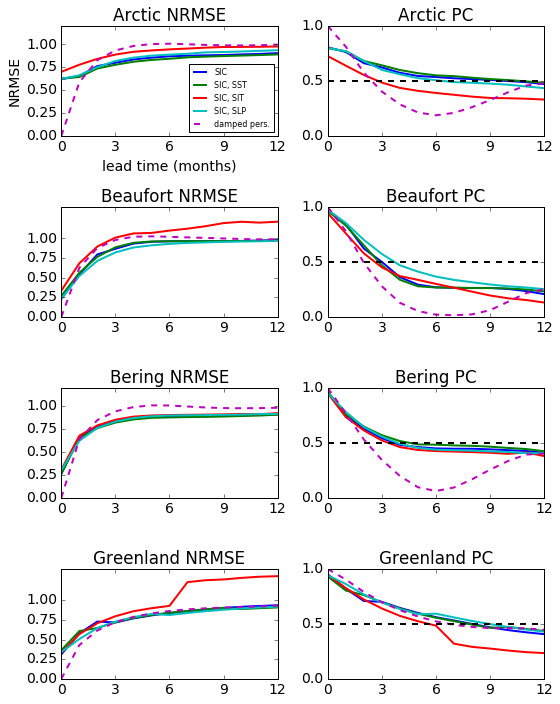

In [32]:
""" Figure 11 """
region = []
region.append('Arctic')
region.append('Beaufort')
region.append('Bering')
region.append('Greenland')
# region.append('Barents')
# region.append('Labrador')
varUsed = []
varUsed.append('SIC')
varUsed.append('SIC_SST')
varUsed.append('SIC_SIT')
varUsed.append('SIC_SLP')
embedWin = 12
iceVar = 'ica'

pred_var_rms = np.zeros((4, 4, 13))
pred_var_pc = np.zeros((4, 4, 13))

pred_var_rmsP = np.zeros((4, 13))
pred_var_pcP = np.zeros((4, 13))

# load Arctic data
dataDir = WORK_DIR + region[0] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 0, :] = data['pred_rms']
pred_var_pc[0, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[0] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 1, :] = data['pred_rms']
pred_var_pc[0, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[0] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 2, :] = data['pred_rms']
pred_var_pc[0, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[0] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 3, :] = data['pred_rms']
pred_var_pc[0, 3, :] = data['pred_pc']

# load Beaufort data
dataDir = WORK_DIR + region[1] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 0, :] = data['pred_rms']
pred_var_pc[1, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[1] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 1, :] = data['pred_rms']
pred_var_pc[1, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[1] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 2, :] = data['pred_rms']
pred_var_pc[1, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[1] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 3, :] = data['pred_rms']
pred_var_pc[1, 3, :] = data['pred_pc']

# load Bering data
dataDir = WORK_DIR + region[2] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 0, :] = data['pred_rms']
pred_var_pc[2, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[2] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 1, :] = data['pred_rms']
pred_var_pc[2, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[2] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 2, :] = data['pred_rms']
pred_var_pc[2, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[2] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 3, :] = data['pred_rms']
pred_var_pc[2, 3, :] = data['pred_pc']

# load Greenland data
dataDir = WORK_DIR + region[3] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[3, 0, :] = data['pred_rms']
pred_var_pc[3, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[3] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[3, 1, :] = data['pred_rms']
pred_var_pc[3, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[3] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[3, 2, :] = data['pred_rms']
pred_var_pc[3, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[3] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[3, 3, :] = data['pred_rms']
pred_var_pc[3, 3, :] = data['pred_pc']

# load persistence data
dataDir = WORK_DIR + region[0] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[0, :] = data['pred_rmsDP']
    pred_var_pcP[0, :] = data['pred_pcDP']
else:
    pred_var_rmsP[0, :] = data['pred_rmsP']
    pred_var_pcP[0, :] = data['pred_pcP']

dataDir = WORK_DIR + region[1] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[1, :] = data['pred_rmsDP']
    pred_var_pcP[1, :] = data['pred_pcDP']
else:
    pred_var_rmsP[1, :] = data['pred_rmsP']
    pred_var_pcP[1, :] = data['pred_pcP']
dataDir = WORK_DIR + region[2] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[2, :] = data['pred_rmsDP']
    pred_var_pcP[2, :] = data['pred_pcDP']
else:
    pred_var_rmsP[2, :] = data['pred_rmsP']
    pred_var_pcP[2, :] = data['pred_pcP']
dataDir = WORK_DIR + region[3] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[3, :] = data['pred_rmsDP']
    pred_var_pcP[3, :] = data['pred_pcDP']
else:
    pred_var_rmsP[3, :] = data['pred_rmsP']
    pred_var_pcP[3, :] = data['pred_pcP']    

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})

tLag = data['tLag']
tt = np.linspace(0, int(tLag) - 1, int(tLag))

thresh = np.ones(tLag) * 0.5

fig = plt.figure()
plt.subplot(4, 2, 1)
plt.plot(tt, pred_var_rms[0, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[0, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[0, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[0, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[0, :], '--', label='damped pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.xlabel('lead time (months)')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.ylabel(r'km$^2$')
plt.ylabel('NRMSE')
plt.legend(loc='lower right', prop={'size': 8})
plt.title(region[0] + ' NRMSE')

plt.subplot(4, 2, 2)
plt.plot(tt, pred_var_pc[0, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[0, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[0, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[0, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[0, :], '--', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title(region[0] + ' PC')

plt.subplot(4, 2, 3)
plt.plot(tt, pred_var_rms[1, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[1, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[1, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[1, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[1, :], '--', label='damped pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.title(region[1] + ' NRMSE')

plt.subplot(4, 2, 4)
plt.plot(tt, pred_var_pc[1, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[1, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[1, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[1, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[1, :], '--', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title(region[1] + ' PC')

plt.subplot(4, 2, 5)
plt.plot(tt, pred_var_rms[2, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[2, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[2, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[2, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[2, :], '--', label='damped pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.title(region[2] + ' NRMSE')

plt.subplot(4, 2, 6)
plt.plot(tt, pred_var_pc[2, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[2, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[2, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[2, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[2, :], '--', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title(region[2] + ' PC')

plt.subplot(4, 2, 7)
plt.plot(tt, pred_var_rms[3, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[3, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[3, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[3, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[3, :], '--', label='damped pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.title(region[3] + ' NRMSE')

plt.subplot(4, 2, 8)
plt.plot(tt, pred_var_pc[3, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[3, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[3, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[3, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[3, :], '--', label='damped pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title(region[3] + ' PC')

fig.set_figheight(10)
fig.set_figwidth(8)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig11.eps', format='eps', dpi=1200)

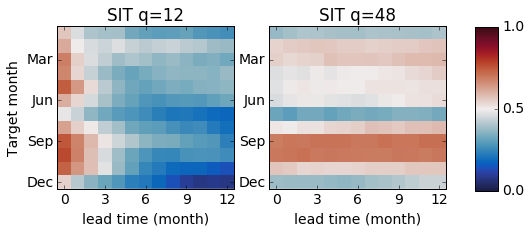

In [16]:
""" Figure 12 """
region = 'Arctic'
embedWin = 12
varsUsed = 'SIC_SST_SIT'

dataDir = WORK_DIR + region + '_SIC_SST_SIT_q' + str(embedWin) + \
    '_train_100_499/'
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTM = dataPredICA['pred_pcIM']

dataDir = WORK_DIR + region + '_SIC_SST_SITq48_q' + str(embedWin) + \
    '_train_100_499/'

dataPredICAS = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTMS = dataPredICAS['pred_pcIM']

# shift due to 12 month embedding window
mM = [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp1 = np.zeros(np.shape(pred_pcTM))
tmp2 = np.zeros(np.shape(pred_pcTM))
tmp1 = pred_pcTM[mM,:]
tmp2 = pred_pcTMS[mM,:]
pred_pcTM = tmp1
pred_pcTMS = tmp2

# shift to target
tmp1 = np.zeros(np.shape(pred_pcTM))
tmp2 = np.zeros(np.shape(pred_pcTMS))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_pcTM[i,j]
        tmp2[newM,j] = pred_pcTMS[i,j]
pred_pcTM = tmp1
pred_pcTMS = tmp2

cTicks = np.linspace(0, 1, 3)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': False})
# plt.rcParams.update({'font.family': 'serif'})

fig = plt.figure()
plt.subplot(121)
plt.imshow(pred_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('SIT q=12')
plt.subplot(122)
plt.imshow(pred_pcTMS,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('SIT q=48')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# cax = plt.axes([0.85, 0.1, 0.075, 0.5])
cax = plt.axes([0.85, 0.21, 0.04, 0.57])

plt.colorbar(cax=cax, ticks=cTicks)
fig.set_figwidth(8)
plt.savefig(SAVE_DIR + 'Fig12.eps', format='eps', dpi=1200)

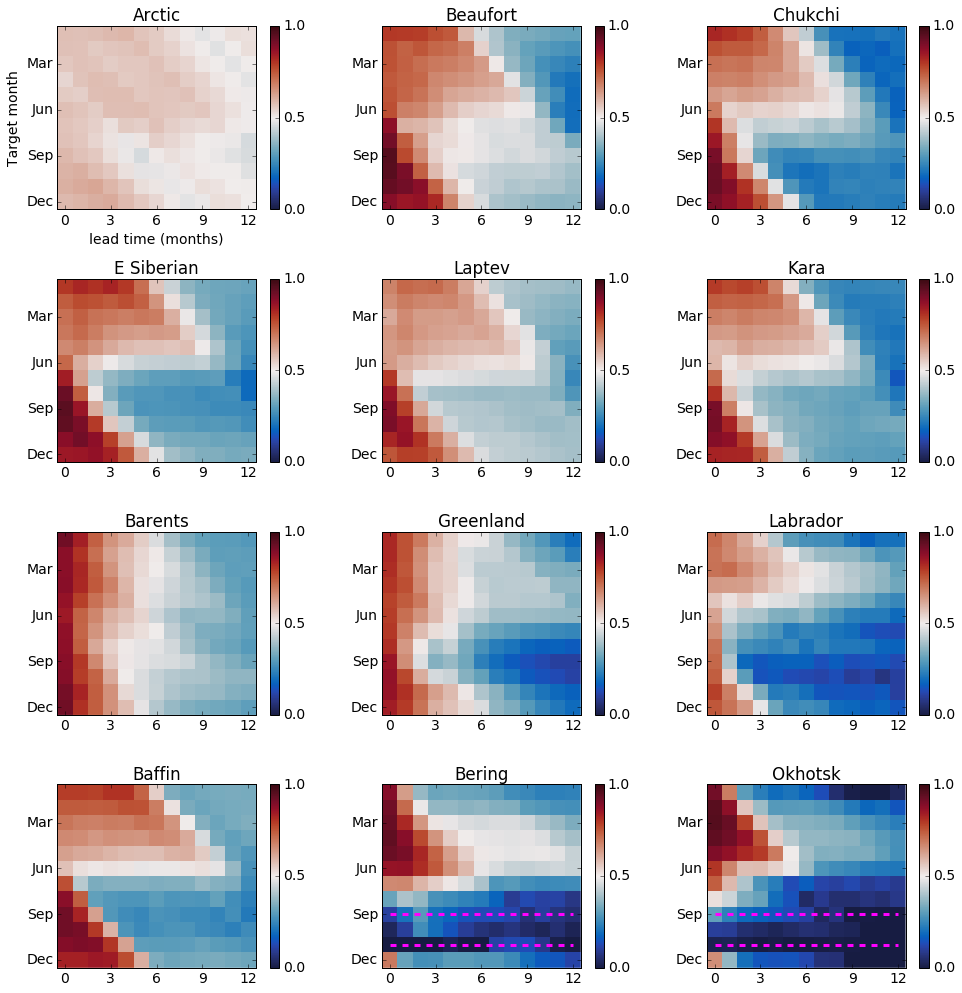

In [17]:
""" Figure 13 """
embedWin = 12
iceVar = 'iva'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_shift_1_pcTM = compData['pred_panel_shift_1_pcIM']
# pred_panel_shift_1_pcTM = compData['pred_panel_shift_17_pcIM']
pred_panel_shift_2_pcTM = compData['pred_panel_shift_2_pcIM']
pred_panel_shift_3_pcTM = compData['pred_panel_shift_3_pcIM']
pred_panel_shift_4_pcTM = compData['pred_panel_shift_4_pcIM']
pred_panel_shift_5_pcTM = compData['pred_panel_shift_5_pcIM']
pred_panel_shift_6_pcTM = compData['pred_panel_shift_6_pcIM']
pred_panel_shift_7_pcTM = compData['pred_panel_shift_7_pcIM']
pred_panel_shift_8_pcTM = compData['pred_panel_shift_8_pcIM']
pred_panel_shift_9_pcTM = compData['pred_panel_shift_9_pcIM']
pred_panel_shift_10_pcTM = compData['pred_panel_shift_10_pcIM']
pred_panel_shift_11_pcTM = compData['pred_panel_shift_11_pcIM']
pred_panel_shift_12_pcTM = compData['pred_panel_shift_12_pcIM']
pred_panel_shift_13_pcTM = compData['pred_panel_shift_13_pcIM']
pred_panel_shift_14_pcTM = compData['pred_panel_shift_14_pcIM']
pred_panel_shift_15_pcTM = compData['pred_panel_shift_15_pcIM']
pred_panel_shift_16_pcTM = compData['pred_panel_shift_16_pcIM']

# shift to target
tmp1 = np.zeros(np.shape(pred_panel_shift_1_pcTM))
tmp2 = np.zeros(np.shape(pred_panel_shift_2_pcTM))
tmp3 = np.zeros(np.shape(pred_panel_shift_3_pcTM))
tmp4 = np.zeros(np.shape(pred_panel_shift_4_pcTM))
tmp5 = np.zeros(np.shape(pred_panel_shift_5_pcTM))
tmp6 = np.zeros(np.shape(pred_panel_shift_6_pcTM))
tmp7 = np.zeros(np.shape(pred_panel_shift_7_pcTM))
tmp8 = np.zeros(np.shape(pred_panel_shift_8_pcTM))
tmp9 = np.zeros(np.shape(pred_panel_shift_9_pcTM))
tmp10 = np.zeros(np.shape(pred_panel_shift_10_pcTM))
tmp11 = np.zeros(np.shape(pred_panel_shift_11_pcTM))
tmp12 = np.zeros(np.shape(pred_panel_shift_12_pcTM))
tmp13 = np.zeros(np.shape(pred_panel_shift_13_pcTM))
tmp14 = np.zeros(np.shape(pred_panel_shift_14_pcTM))
tmp15 = np.zeros(np.shape(pred_panel_shift_15_pcTM))
tmp16 = np.zeros(np.shape(pred_panel_shift_16_pcTM))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_panel_shift_1_pcTM[i,j]
        tmp2[newM,j] = pred_panel_shift_2_pcTM[i,j]
        tmp3[newM,j] = pred_panel_shift_3_pcTM[i,j]
        tmp4[newM,j] = pred_panel_shift_4_pcTM[i,j]
        tmp5[newM,j] = pred_panel_shift_5_pcTM[i,j]
        tmp6[newM,j] = pred_panel_shift_6_pcTM[i,j]
        tmp7[newM,j] = pred_panel_shift_7_pcTM[i,j]
        tmp8[newM,j] = pred_panel_shift_8_pcTM[i,j] 
        tmp9[newM,j] = pred_panel_shift_9_pcTM[i,j]
        tmp10[newM,j] = pred_panel_shift_10_pcTM[i,j]
        tmp11[newM,j] = pred_panel_shift_11_pcTM[i,j]
        tmp12[newM,j] = pred_panel_shift_12_pcTM[i,j] 
        tmp13[newM,j] = pred_panel_shift_13_pcTM[i,j]
        tmp14[newM,j] = pred_panel_shift_14_pcTM[i,j]
        tmp15[newM,j] = pred_panel_shift_15_pcTM[i,j]
        tmp16[newM,j] = pred_panel_shift_16_pcTM[i,j]
pred_panel_shift_1_pcTM = tmp1
pred_panel_shift_2_pcTM = tmp2
pred_panel_shift_3_pcTM = tmp3
pred_panel_shift_4_pcTM = tmp4
pred_panel_shift_5_pcTM = tmp5
pred_panel_shift_6_pcTM = tmp6
pred_panel_shift_7_pcTM = tmp7
pred_panel_shift_8_pcTM = tmp8
pred_panel_shift_9_pcTM = tmp9
pred_panel_shift_10_pcTM = tmp10
pred_panel_shift_11_pcTM = tmp11
pred_panel_shift_12_pcTM = tmp12
pred_panel_shift_13_pcTM = tmp13
pred_panel_shift_14_pcTM = tmp14
pred_panel_shift_15_pcTM = tmp15
pred_panel_shift_16_pcTM = tmp16

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(0, 1, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig13.eps', format='eps', dpi=500)

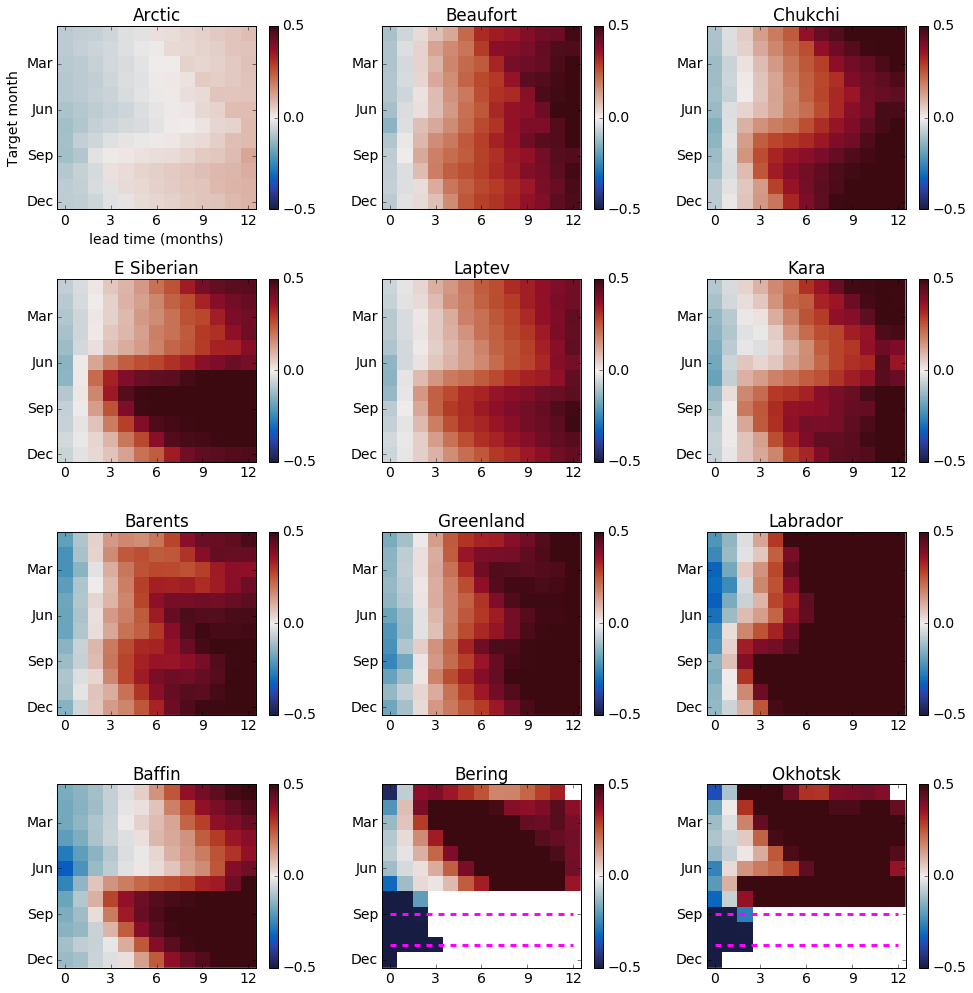

In [18]:
""" Figure 14 """
embedWin = 12
iceVar = 'iva'
varsUsed = 'SIC_SST_SITq48'
std_thresh = 0.01

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'
compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')
tLag = compData['tLag']

if dampedP == 1:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcIMDdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcIMDdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcIMDdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcIMDdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcIMDdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcIMDdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcIMDdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcIMDdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcIMDdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcIMDdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcIMDdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcIMDdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcIMDdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcIMDdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcIMDdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcIMDdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcIMDdiff']
else:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcIMdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcIMdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcIMdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcIMdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcIMdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcIMdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcIMdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcIMdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcIMdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcIMdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcIMdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcIMdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcIMdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcIMdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcIMdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcIMdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcIMdiff']

# shift to target
tmp1 = np.zeros(np.shape(pred_panel_shift_1_pcTMdiff))
tmp2 = np.zeros(np.shape(pred_panel_shift_2_pcTMdiff))
tmp3 = np.zeros(np.shape(pred_panel_shift_3_pcTMdiff))
tmp4 = np.zeros(np.shape(pred_panel_shift_4_pcTMdiff))
tmp5 = np.zeros(np.shape(pred_panel_shift_5_pcTMdiff))
tmp6 = np.zeros(np.shape(pred_panel_shift_6_pcTMdiff))
tmp7 = np.zeros(np.shape(pred_panel_shift_7_pcTMdiff))
tmp8 = np.zeros(np.shape(pred_panel_shift_8_pcTMdiff))
tmp9 = np.zeros(np.shape(pred_panel_shift_9_pcTMdiff))
tmp10 = np.zeros(np.shape(pred_panel_shift_10_pcTMdiff))
tmp11 = np.zeros(np.shape(pred_panel_shift_11_pcTMdiff))
tmp12 = np.zeros(np.shape(pred_panel_shift_12_pcTMdiff))
tmp13 = np.zeros(np.shape(pred_panel_shift_13_pcTMdiff))
tmp14 = np.zeros(np.shape(pred_panel_shift_14_pcTMdiff))
tmp15 = np.zeros(np.shape(pred_panel_shift_15_pcTMdiff))
tmp16 = np.zeros(np.shape(pred_panel_shift_16_pcTMdiff))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_panel_shift_1_pcTMdiff[i,j]
        tmp2[newM,j] = pred_panel_shift_2_pcTMdiff[i,j]
        tmp3[newM,j] = pred_panel_shift_3_pcTMdiff[i,j]
        tmp4[newM,j] = pred_panel_shift_4_pcTMdiff[i,j]
        tmp5[newM,j] = pred_panel_shift_5_pcTMdiff[i,j]
        tmp6[newM,j] = pred_panel_shift_6_pcTMdiff[i,j]
        tmp7[newM,j] = pred_panel_shift_7_pcTMdiff[i,j]
        tmp8[newM,j] = pred_panel_shift_8_pcTMdiff[i,j] 
        tmp9[newM,j] = pred_panel_shift_9_pcTMdiff[i,j]
        tmp10[newM,j] = pred_panel_shift_10_pcTMdiff[i,j]
        tmp11[newM,j] = pred_panel_shift_11_pcTMdiff[i,j]
        tmp12[newM,j] = pred_panel_shift_12_pcTMdiff[i,j] 
        tmp13[newM,j] = pred_panel_shift_13_pcTMdiff[i,j]
        tmp14[newM,j] = pred_panel_shift_14_pcTMdiff[i,j]
        tmp15[newM,j] = pred_panel_shift_15_pcTMdiff[i,j]
        tmp16[newM,j] = pred_panel_shift_16_pcTMdiff[i,j]
pred_panel_shift_1_pcTMdiff = tmp1
pred_panel_shift_2_pcTMdiff = tmp2
pred_panel_shift_3_pcTMdiff = tmp3
pred_panel_shift_4_pcTMdiff = tmp4
pred_panel_shift_5_pcTMdiff = tmp5
pred_panel_shift_6_pcTMdiff = tmp6
pred_panel_shift_7_pcTMdiff = tmp7
pred_panel_shift_8_pcTMdiff = tmp8
pred_panel_shift_9_pcTMdiff = tmp9
pred_panel_shift_10_pcTMdiff = tmp10
pred_panel_shift_11_pcTMdiff = tmp11
pred_panel_shift_12_pcTMdiff = tmp12
pred_panel_shift_13_pcTMdiff = tmp13
pred_panel_shift_14_pcTMdiff = tmp14
pred_panel_shift_15_pcTMdiff = tmp15
pred_panel_shift_16_pcTMdiff = tmp16
    
plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(-0.5, 0.5, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTMdiff,
           cmap=cmocean.cm.balance,
           clim=(-0.5, 0.5),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.plot([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], color='magenta', linestyle='--', linewidth=3)
plt.plot([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], color='magenta', linestyle='--', linewidth=3)
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig14.eps', format='eps', dpi=500)

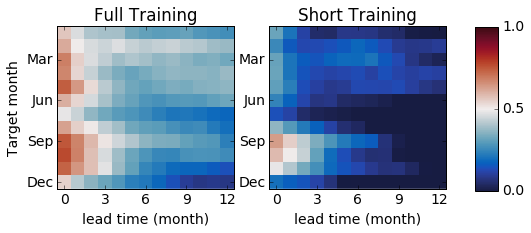

In [154]:
""" Figure 15 """
region = 'Arctic'
embedWin = 12
varsUsed = 'SIC_SST_SIT'

# full training data
dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTM = dataPredICA['pred_pcIM']


# short training data
dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_139/'
dataPredICAS = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTMS = dataPredICAS['pred_pcIM']

# shift due to 12 month embedding window
mM = [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp1 = np.zeros(np.shape(pred_pcTM))
tmp2 = np.zeros(np.shape(pred_pcTM))
tmp1 = pred_pcTM[mM, :]
tmp2 = pred_pcTMS[mM, :]
pred_pcTM = tmp1
pred_pcTMS = tmp2

# shift to target
tmp1 = np.zeros(np.shape(pred_pcTM))
tmp2 = np.zeros(np.shape(pred_pcTMS))
for i in range(12):
    for j in range(13):
        newM = i + j
        if newM > 11:
            newM -= 12
        tmp1[newM,j] = pred_pcTM[i,j]
        tmp2[newM,j] = pred_pcTMS[i,j]
pred_pcTM = tmp1
pred_pcTMS = tmp2

cTicks = np.linspace(0, 1, 3)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': False})

fig = plt.figure()
plt.subplot(121)
plt.imshow(pred_pcTM,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('Full Training')
plt.subplot(122)
plt.imshow(pred_pcTMS,
           cmap=cmocean.cm.balance,
           clim=(0, 1),
           interpolation='none')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Short Training')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.21, 0.04, 0.57])

plt.colorbar(cax=cax, ticks=cTicks)
fig.set_figwidth(8)
plt.savefig(SAVE_DIR + 'Fig15.eps', format='eps', dpi=1200)

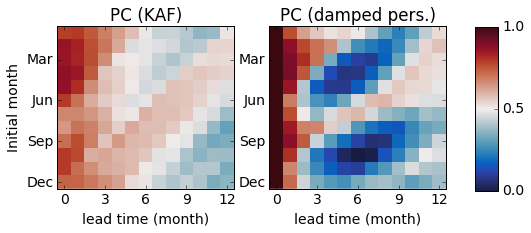

In [27]:
# """ Figure 8 """
# embedWin = 12
# iceVar = 'ica'
# varsUsed = 'SIC_SST_SLP'

# dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
#     '_train_100_499/'

# compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

# tLag = compData['tLag']

# # pred_panel_shift_1_pcTM = compData['pred_panel_shift_1_pcIM']
# # pred_panel_shift_2_pcTM = compData['pred_panel_shift_2_pcIM']
# # pred_panel_shift_3_pcTM = compData['pred_panel_shift_3_pcIM']
# # pred_panel_shift_4_pcTM = compData['pred_panel_shift_4_pcIM']
# # pred_panel_shift_5_pcTM = compData['pred_panel_shift_5_pcIM']
# # pred_panel_shift_6_pcTM = compData['pred_panel_shift_6_pcIM']
# # pred_panel_shift_7_pcTM = compData['pred_panel_shift_7_pcIM']
# # pred_panel_shift_8_pcTM = compData['pred_panel_shift_8_pcIM']
# # pred_panel_shift_9_pcTM = compData['pred_panel_shift_9_pcIM']
# # pred_panel_shift_10_pcTM = compData['pred_panel_shift_10_pcIM']
# # pred_panel_shift_11_pcTM = compData['pred_panel_shift_11_pcIM']
# # pred_panel_shift_12_pcTM = compData['pred_panel_shift_12_pcIM']
# # pred_panel_shift_13_pcTM = compData['pred_panel_shift_13_pcIM']
# # pred_panel_shift_14_pcTM = compData['pred_panel_shift_14_pcIM']
# # pred_panel_shift_15_pcTM = compData['pred_panel_shift_15_pcIM']
# # pred_panel_shift_16_pcTM = compData['pred_panel_shift_16_pcIM']

# pred_panel_shift_1_pcTM = compData['pred_panel_1_pcIMP']
# pred_panel_shift_2_pcTM = compData['pred_panel_2_pcIMP']
# pred_panel_shift_3_pcTM = compData['pred_panel_3_pcIMP']
# pred_panel_shift_4_pcTM = compData['pred_panel_4_pcIMP']
# pred_panel_shift_5_pcTM = compData['pred_panel_5_pcIMP']
# pred_panel_shift_6_pcTM = compData['pred_panel_6_pcIMP']
# pred_panel_shift_7_pcTM = compData['pred_panel_7_pcIMP']
# pred_panel_shift_8_pcTM = compData['pred_panel_8_pcIMP']
# pred_panel_shift_9_pcTM = compData['pred_panel_9_pcIMP']
# pred_panel_shift_10_pcTM = compData['pred_panel_10_pcIMP']
# pred_panel_shift_11_pcTM = compData['pred_panel_11_pcIMP']
# pred_panel_shift_12_pcTM = compData['pred_panel_12_pcIMP']
# pred_panel_shift_13_pcTM = compData['pred_panel_13_pcIMP']
# pred_panel_shift_14_pcTM = compData['pred_panel_14_pcIMP']
# pred_panel_shift_15_pcTM = compData['pred_panel_15_pcIMP']
# pred_panel_shift_16_pcTM = compData['pred_panel_16_pcIMP']

# # shift to target
# tmp1 = np.zeros(np.shape(pred_panel_shift_1_pcTM))
# tmp2 = np.zeros(np.shape(pred_panel_shift_2_pcTM))
# tmp3 = np.zeros(np.shape(pred_panel_shift_3_pcTM))
# tmp4 = np.zeros(np.shape(pred_panel_shift_4_pcTM))
# tmp5 = np.zeros(np.shape(pred_panel_shift_5_pcTM))
# tmp6 = np.zeros(np.shape(pred_panel_shift_6_pcTM))
# tmp7 = np.zeros(np.shape(pred_panel_shift_7_pcTM))
# tmp8 = np.zeros(np.shape(pred_panel_shift_8_pcTM))
# tmp9 = np.zeros(np.shape(pred_panel_shift_9_pcTM))
# tmp10 = np.zeros(np.shape(pred_panel_shift_10_pcTM))
# tmp11 = np.zeros(np.shape(pred_panel_shift_11_pcTM))
# tmp12 = np.zeros(np.shape(pred_panel_shift_12_pcTM))
# tmp13 = np.zeros(np.shape(pred_panel_shift_13_pcTM))
# tmp14 = np.zeros(np.shape(pred_panel_shift_14_pcTM))
# tmp15 = np.zeros(np.shape(pred_panel_shift_15_pcTM))
# tmp16 = np.zeros(np.shape(pred_panel_shift_16_pcTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_panel_shift_1_pcTM[i,j]
#         tmp2[newM,j] = pred_panel_shift_2_pcTM[i,j]
#         tmp3[newM,j] = pred_panel_shift_3_pcTM[i,j]
#         tmp4[newM,j] = pred_panel_shift_4_pcTM[i,j]
#         tmp5[newM,j] = pred_panel_shift_5_pcTM[i,j]
#         tmp6[newM,j] = pred_panel_shift_6_pcTM[i,j]
#         tmp7[newM,j] = pred_panel_shift_7_pcTM[i,j]
#         tmp8[newM,j] = pred_panel_shift_8_pcTM[i,j] 
#         tmp9[newM,j] = pred_panel_shift_9_pcTM[i,j]
#         tmp10[newM,j] = pred_panel_shift_10_pcTM[i,j]
#         tmp11[newM,j] = pred_panel_shift_11_pcTM[i,j]
#         tmp12[newM,j] = pred_panel_shift_12_pcTM[i,j] 
#         tmp13[newM,j] = pred_panel_shift_13_pcTM[i,j]
#         tmp14[newM,j] = pred_panel_shift_14_pcTM[i,j]
#         tmp15[newM,j] = pred_panel_shift_15_pcTM[i,j]
#         tmp16[newM,j] = pred_panel_shift_16_pcTM[i,j]
# pred_panel_shift_1_pcTM = tmp1
# pred_panel_shift_2_pcTM = tmp2
# pred_panel_shift_3_pcTM = tmp3
# pred_panel_shift_4_pcTM = tmp4
# pred_panel_shift_5_pcTM = tmp5
# pred_panel_shift_6_pcTM = tmp6
# pred_panel_shift_7_pcTM = tmp7
# pred_panel_shift_8_pcTM = tmp8
# pred_panel_shift_9_pcTM = tmp9
# pred_panel_shift_10_pcTM = tmp10
# pred_panel_shift_11_pcTM = tmp11
# pred_panel_shift_12_pcTM = tmp12
# pred_panel_shift_13_pcTM = tmp13
# pred_panel_shift_14_pcTM = tmp14
# pred_panel_shift_15_pcTM = tmp15
# pred_panel_shift_16_pcTM = tmp16

# plt.rcParams.update({'font.size': 14})
# # plt.rcParams.update({'font.family': 'serif'})

# cTicks = np.linspace(0, 1, 3)
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

# fig = plt.figure()
# plt.subplot(4, 3, 1)
# plt.imshow(pred_panel_shift_1_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Target month')
# plt.title('Arctic')
# # plt.title('Central Arctic')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 2)
# plt.imshow(pred_panel_shift_4_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Beaufort')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 3)
# plt.imshow(pred_panel_shift_3_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Chukchi')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 4)
# plt.imshow(pred_panel_shift_6_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('E Siberian')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 5)
# plt.imshow(pred_panel_shift_7_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Laptev')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 6)
# plt.imshow(pred_panel_shift_10_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Kara')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 7)
# plt.imshow(pred_panel_shift_9_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Barents')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 8)
# plt.imshow(pred_panel_shift_11_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Greenland')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 9)
# plt.imshow(pred_panel_shift_13_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Labrador')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 10)
# plt.imshow(pred_panel_shift_12_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Baffin')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 11)
# plt.imshow(pred_panel_shift_15_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Bering')
# plt.colorbar().set_ticks(cTicks)

# plt.subplot(4, 3, 12)
# plt.imshow(pred_panel_shift_16_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Okhotsk')
# plt.colorbar().set_ticks(cTicks)

# fig.set_figheight(14)
# fig.set_figwidth(14)
# plt.tight_layout()
# # plt.savefig(SAVE_DIR + 'Fig8.eps', format='eps', dpi=500)
# plt.savefig(SAVE_DIR + 'Fig8_persistence.png')

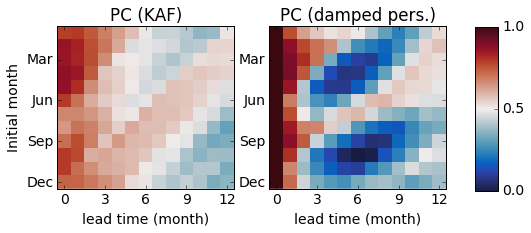

In [18]:
# """ Figure 4 """
# embedWin = 12
# region = 'Arctic'
# varsUsed = 'SIC_SST_SLP'

# dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
#     '_train_100_499/'

# # concentration anomaly data
# dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')

# pred_pcTM = dataPredICA['pred_pcIM']
# if dampedP == 1:
#     pred_pcTMP = dataPredICA['pred_pcIMDP']
# else:
#     pred_pcTMP = dataPredICA['pred_pcIMP']
# std_truthTM = dataPredICA['std_truthTM']

# # shift due to 12 month embedding window
# mM = [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# tmp1 = np.zeros(np.shape(pred_pcTM))
# tmp2 = np.zeros(np.shape(pred_pcTM))
# tmp3 = np.zeros(np.shape(pred_pcTM))
# tmp1 = pred_pcTM[mM,:]
# tmp2 = pred_pcTMP[mM,:]
# tmp3 = std_truthTM[mM,:]
# pred_pcTM = tmp1
# pred_pcTMP = tmp2
# std_truthTM = tmp3

# # mask out small variances
# pred_pcTM[std_truthTM < std_thresh] = np.nan
# pred_pcTMP[std_truthTM < std_thresh] = np.nan

# cTicks = np.linspace(0, 1, 3)

# plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'figure.autolayout': False})
# # plt.rcParams.update({'font.family': 'serif'})

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(pred_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
# yLabelsN = ['M', 'J', 'S', 'D']
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Initial month')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (month)')
# plt.title('PC (KAF)')
# plt.subplot(122)
# plt.imshow(pred_pcTMP,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (month)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('PC (damped pers.)')

# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# # cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# # cax = plt.axes([0.85, 0.1, 0.075, 0.5])
# cax = plt.axes([0.85, 0.21, 0.04, 0.57])

# plt.colorbar(cax=cax, ticks=cTicks)
# fig.set_figwidth(8)
# plt.savefig(SAVE_DIR + 'Fig4IM.eps', format='eps', dpi=1200)

(12, 13)

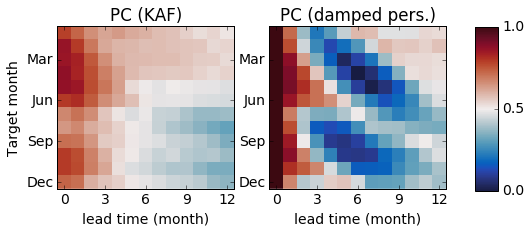

In [42]:
# """ Figure 4 """
# embedWin = 12
# region = 'Arctic'
# varsUsed = 'SIC_SST_SLP'

# dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
#     '_train_100_499/'

# # concentration anomaly data
# dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')

# pred_pcTM = dataPredICA['pred_pcIM']
# if dampedP == 1:
#     pred_pcTMP = dataPredICA['pred_pcIMDP']
# else:
#     pred_pcTMP = dataPredICA['pred_pcIMP']
# std_truthTM = dataPredICA['std_truthTM']

# # shift due to 12 month embedding window
# mM = [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# tmp1 = np.zeros(np.shape(pred_pcTM))
# tmp2 = np.zeros(np.shape(pred_pcTM))
# tmp3 = np.zeros(np.shape(pred_pcTM))
# tmp1 = pred_pcTM[mM,:]
# tmp2 = pred_pcTMP[mM,:]
# tmp3 = std_truthTM[mM,:]
# pred_pcTM = tmp1
# pred_pcTMP = tmp2
# std_truthTM = tmp3

# # shift to target
# tmp1 = np.zeros(np.shape(pred_pcTM))
# tmp2 = np.zeros(np.shape(pred_pcTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_pcTM[i,j]
#         tmp2[newM,j] = pred_pcTMP[i,j]
# pred_pcTM = tmp1
# pred_pcTMP = tmp2

# # mask out small variances
# pred_pcTM[std_truthTM < std_thresh] = np.nan
# pred_pcTMP[std_truthTM < std_thresh] = np.nan

# cTicks = np.linspace(0, 1, 3)

# plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'figure.autolayout': False})
# # plt.rcParams.update({'font.family': 'serif'})

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(pred_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
# yLabelsN = ['M', 'J', 'S', 'D']
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Target month')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (month)')
# plt.title('PC (KAF)')
# plt.subplot(122)
# plt.imshow(pred_pcTMP,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (month)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('PC (damped pers.)')

# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# # cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# # cax = plt.axes([0.85, 0.1, 0.075, 0.5])
# cax = plt.axes([0.85, 0.21, 0.04, 0.57])


# plt.colorbar(cax=cax, ticks=cTicks)
# fig.set_figwidth(8)
# # plt.savefig(SAVE_DIR + 'Fig4TMfromIM.eps', format='eps', dpi=1200)
# plt.savefig(SAVE_DIR + 'Fig4TMfromIM.png')

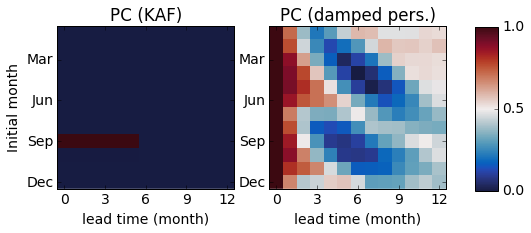

In [36]:
# """ Figure 4 """
# embedWin = 12
# region = 'Arctic'
# varsUsed = 'SIC_SST_SLP'

# dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
#     '_train_100_499/'

# # concentration anomaly data
# dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')

# pred_pcTM = dataPredICA['pred_pcIM']
# if dampedP == 1:
#     pred_pcTMP = dataPredICA['pred_pcIMDP']
# else:
#     pred_pcTMP = dataPredICA['pred_pcIMP']
# std_truthTM = dataPredICA['std_truthTM']

# # shift due to 12 month embedding window
# mM = [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# tmp1 = np.zeros(np.shape(pred_pcTM))
# tmp2 = np.zeros(np.shape(pred_pcTM))
# tmp3 = np.zeros(np.shape(pred_pcTM))
# tmp1 = pred_pcTM[mM,:]
# tmp2 = pred_pcTMP[mM,:]
# tmp3 = std_truthTM[mM,:]
# pred_pcTM = tmp1
# pred_pcTMP = tmp2
# std_truthTM = tmp3

# pred_pcTM = np.zeros((12,13))
# pred_pcTM[8,0] = 1
# pred_pcTM[7,1] = 1
# pred_pcTM[6,2] = 1
# pred_pcTM[5,3] = 1
# pred_pcTM[4,4] = 1
# pred_pcTM[3,5] = 1

# # shift to target
# tmp1 = np.zeros(np.shape(pred_pcTM))
# tmp2 = np.zeros(np.shape(pred_pcTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_pcTM[i,j]
#         tmp2[newM,j] = pred_pcTMP[i,j]        
# pred_pcTM = tmp1
# pred_pcTMP = tmp2

# # mask out small variances
# pred_pcTM[std_truthTM < std_thresh] = np.nan
# pred_pcTMP[std_truthTM < std_thresh] = np.nan

# cTicks = np.linspace(0, 1, 3)

# plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'figure.autolayout': False})
# # plt.rcParams.update({'font.family': 'serif'})

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(pred_pcTM,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
# yLabelsN = ['M', 'J', 'S', 'D']
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Initial month')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (month)')
# plt.title('PC (KAF)')
# plt.subplot(122)
# plt.imshow(pred_pcTMP,
#            cmap=cmocean.cm.balance,
#            clim=(0, 1),
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (month)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('PC (damped pers.)')

# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# # cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# # cax = plt.axes([0.85, 0.1, 0.075, 0.5])
# cax = plt.axes([0.85, 0.21, 0.04, 0.57])


# plt.colorbar(cax=cax, ticks=cTicks)
# fig.set_figwidth(8)
# plt.savefig(SAVE_DIR + 'Fig4Test.eps', format='eps', dpi=1200)

In [ ]:
# """ Figure STDs """
# embedWin = 12
# iceVar = 'ica'
# varsUsed = 'SIC_SST_SLP'

# dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
#     '_train_100_499/'

# compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

# tLag = compData['tLag']

# # mask out small variances
# pred_panel_shift_1_stdTM = compData['pred_panel_shift_1_stdIM']
# pred_panel_shift_2_stdTM = compData['pred_panel_shift_2_stdIM']
# pred_panel_shift_3_stdTM = compData['pred_panel_shift_3_stdIM']
# pred_panel_shift_4_stdTM = compData['pred_panel_shift_4_stdIM']
# pred_panel_shift_5_stdTM = compData['pred_panel_shift_5_stdIM']
# pred_panel_shift_6_stdTM = compData['pred_panel_shift_6_stdIM']
# pred_panel_shift_7_stdTM = compData['pred_panel_shift_7_stdIM']
# pred_panel_shift_8_stdTM = compData['pred_panel_shift_8_stdIM']
# pred_panel_shift_9_stdTM = compData['pred_panel_shift_9_stdIM']
# pred_panel_shift_10_stdTM = compData['pred_panel_shift_10_stdIM']
# pred_panel_shift_11_stdTM = compData['pred_panel_shift_11_stdIM']
# pred_panel_shift_12_stdTM = compData['pred_panel_shift_12_stdIM']
# pred_panel_shift_13_stdTM = compData['pred_panel_shift_13_stdIM']
# pred_panel_shift_14_stdTM = compData['pred_panel_shift_14_stdIM']
# pred_panel_shift_15_stdTM = compData['pred_panel_shift_15_stdIM']
# pred_panel_shift_16_stdTM = compData['pred_panel_shift_16_stdIM']

# # shift to target
# tmp1 = np.zeros(np.shape(pred_panel_shift_1_stdTM))
# tmp2 = np.zeros(np.shape(pred_panel_shift_2_stdTM))
# tmp3 = np.zeros(np.shape(pred_panel_shift_3_stdTM))
# tmp4 = np.zeros(np.shape(pred_panel_shift_4_stdTM))
# tmp5 = np.zeros(np.shape(pred_panel_shift_5_stdTM))
# tmp6 = np.zeros(np.shape(pred_panel_shift_6_stdTM))
# tmp7 = np.zeros(np.shape(pred_panel_shift_7_stdTM))
# tmp8 = np.zeros(np.shape(pred_panel_shift_8_stdTM))
# tmp9 = np.zeros(np.shape(pred_panel_shift_9_stdTM))
# tmp10 = np.zeros(np.shape(pred_panel_shift_10_stdTM))
# tmp11 = np.zeros(np.shape(pred_panel_shift_11_stdTM))
# tmp12 = np.zeros(np.shape(pred_panel_shift_12_stdTM))
# tmp13 = np.zeros(np.shape(pred_panel_shift_13_stdTM))
# tmp14 = np.zeros(np.shape(pred_panel_shift_14_stdTM))
# tmp15 = np.zeros(np.shape(pred_panel_shift_15_stdTM))
# tmp16 = np.zeros(np.shape(pred_panel_shift_16_stdTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_panel_shift_1_stdTM[i,j]
#         tmp2[newM,j] = pred_panel_shift_2_stdTM[i,j]
#         tmp3[newM,j] = pred_panel_shift_3_stdTM[i,j]
#         tmp4[newM,j] = pred_panel_shift_4_stdTM[i,j]
#         tmp5[newM,j] = pred_panel_shift_5_stdTM[i,j]
#         tmp6[newM,j] = pred_panel_shift_6_stdTM[i,j]
#         tmp7[newM,j] = pred_panel_shift_7_stdTM[i,j]
#         tmp8[newM,j] = pred_panel_shift_8_stdTM[i,j] 
#         tmp9[newM,j] = pred_panel_shift_9_stdTM[i,j]
#         tmp10[newM,j] = pred_panel_shift_10_stdTM[i,j]
#         tmp11[newM,j] = pred_panel_shift_11_stdTM[i,j]
#         tmp12[newM,j] = pred_panel_shift_12_stdTM[i,j] 
#         tmp13[newM,j] = pred_panel_shift_13_stdTM[i,j]
#         tmp14[newM,j] = pred_panel_shift_14_stdTM[i,j]
#         tmp15[newM,j] = pred_panel_shift_15_stdTM[i,j]
#         tmp16[newM,j] = pred_panel_shift_16_stdTM[i,j]
# pred_panel_shift_1_stdTM = tmp1
# pred_panel_shift_2_stdTM = tmp2
# pred_panel_shift_3_stdTM = tmp3
# pred_panel_shift_4_stdTM = tmp4
# pred_panel_shift_5_stdTM = tmp5
# pred_panel_shift_6_stdTM = tmp6
# pred_panel_shift_7_stdTM = tmp7
# pred_panel_shift_8_stdTM = tmp8
# pred_panel_shift_9_stdTM = tmp9
# pred_panel_shift_10_stdTM = tmp10
# pred_panel_shift_11_stdTM = tmp11
# pred_panel_shift_12_stdTM = tmp12
# pred_panel_shift_13_stdTM = tmp13
# pred_panel_shift_14_stdTM = tmp14
# pred_panel_shift_15_stdTM = tmp15
# pred_panel_shift_16_stdTM = tmp16

# plt.rcParams.update({'font.size': 14})
# # plt.rcParams.update({'font.family': 'serif'})

# cTicks = np.linspace(0, 1, 3)
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

# fig = plt.figure()
# plt.subplot(4, 3, 1)
# plt.imshow(pred_panel_shift_1_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Target month')
# plt.title('Arctic')
# # plt.title('Central Arctic')
# plt.colorbar()

# plt.subplot(4, 3, 2)
# plt.imshow(pred_panel_shift_4_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Beaufort')
# plt.colorbar()

# plt.subplot(4, 3, 3)
# plt.imshow(pred_panel_shift_3_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Chukchi')
# plt.colorbar()

# plt.subplot(4, 3, 4)
# plt.imshow(pred_panel_shift_6_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('E Siberian')
# plt.colorbar()

# plt.subplot(4, 3, 5)
# plt.imshow(pred_panel_shift_7_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Laptev')
# plt.colorbar()

# plt.subplot(4, 3, 6)
# plt.imshow(pred_panel_shift_10_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Kara')
# plt.colorbar()

# plt.subplot(4, 3, 7)
# plt.imshow(pred_panel_shift_9_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Barents')
# plt.colorbar()

# plt.subplot(4, 3, 8)
# plt.imshow(pred_panel_shift_11_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Greenland')
# plt.colorbar()

# plt.subplot(4, 3, 9)
# plt.imshow(pred_panel_shift_13_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Labrador')
# plt.colorbar()

# plt.subplot(4, 3, 10)
# plt.imshow(pred_panel_shift_12_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Baffin')
# plt.colorbar()

# plt.subplot(4, 3, 11)
# plt.imshow(pred_panel_shift_15_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Bering')
# plt.colorbar()

# plt.subplot(4, 3, 12)
# plt.imshow(pred_panel_shift_16_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Okhotsk')
# plt.colorbar()

# fig.set_figheight(14)
# fig.set_figwidth(14)
# plt.tight_layout()
# # plt.savefig(SAVE_DIR + 'ica_std.eps', format='eps', dpi=500)
# plt.savefig(SAVE_DIR + 'ica_std.png')

# # mask out small variances
# pred_panel_shift_1_NstdTM = compData['pred_panel_shift_1_NstdIM']
# pred_panel_shift_2_NstdTM = compData['pred_panel_shift_2_NstdIM']
# pred_panel_shift_3_NstdTM = compData['pred_panel_shift_3_NstdIM']
# pred_panel_shift_4_NstdTM = compData['pred_panel_shift_4_NstdIM']
# pred_panel_shift_5_NstdTM = compData['pred_panel_shift_5_NstdIM']
# pred_panel_shift_6_NstdTM = compData['pred_panel_shift_6_NstdIM']
# pred_panel_shift_7_NstdTM = compData['pred_panel_shift_7_NstdIM']
# pred_panel_shift_8_NstdTM = compData['pred_panel_shift_8_NstdIM']
# pred_panel_shift_9_NstdTM = compData['pred_panel_shift_9_NstdIM']
# pred_panel_shift_10_NstdTM = compData['pred_panel_shift_10_NstdIM']
# pred_panel_shift_11_NstdTM = compData['pred_panel_shift_11_NstdIM']
# pred_panel_shift_12_NstdTM = compData['pred_panel_shift_12_NstdIM']
# pred_panel_shift_13_NstdTM = compData['pred_panel_shift_13_NstdIM']
# pred_panel_shift_14_NstdTM = compData['pred_panel_shift_14_NstdIM']
# pred_panel_shift_15_NstdTM = compData['pred_panel_shift_15_NstdIM']
# pred_panel_shift_16_NstdTM = compData['pred_panel_shift_16_NstdIM']

# # shift to target
# tmp1 = np.zeros(np.shape(pred_panel_shift_1_NstdTM))
# tmp2 = np.zeros(np.shape(pred_panel_shift_2_NstdTM))
# tmp3 = np.zeros(np.shape(pred_panel_shift_3_NstdTM))
# tmp4 = np.zeros(np.shape(pred_panel_shift_4_NstdTM))
# tmp5 = np.zeros(np.shape(pred_panel_shift_5_NstdTM))
# tmp6 = np.zeros(np.shape(pred_panel_shift_6_NstdTM))
# tmp7 = np.zeros(np.shape(pred_panel_shift_7_NstdTM))
# tmp8 = np.zeros(np.shape(pred_panel_shift_8_NstdTM))
# tmp9 = np.zeros(np.shape(pred_panel_shift_9_NstdTM))
# tmp10 = np.zeros(np.shape(pred_panel_shift_10_NstdTM))
# tmp11 = np.zeros(np.shape(pred_panel_shift_11_NstdTM))
# tmp12 = np.zeros(np.shape(pred_panel_shift_12_NstdTM))
# tmp13 = np.zeros(np.shape(pred_panel_shift_13_NstdTM))
# tmp14 = np.zeros(np.shape(pred_panel_shift_14_NstdTM))
# tmp15 = np.zeros(np.shape(pred_panel_shift_15_NstdTM))
# tmp16 = np.zeros(np.shape(pred_panel_shift_16_NstdTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_panel_shift_1_NstdTM[i,j]
#         tmp2[newM,j] = pred_panel_shift_2_NstdTM[i,j]
#         tmp3[newM,j] = pred_panel_shift_3_NstdTM[i,j]
#         tmp4[newM,j] = pred_panel_shift_4_NstdTM[i,j]
#         tmp5[newM,j] = pred_panel_shift_5_NstdTM[i,j]
#         tmp6[newM,j] = pred_panel_shift_6_NstdTM[i,j]
#         tmp7[newM,j] = pred_panel_shift_7_NstdTM[i,j]
#         tmp8[newM,j] = pred_panel_shift_8_NstdTM[i,j] 
#         tmp9[newM,j] = pred_panel_shift_9_NstdTM[i,j]
#         tmp10[newM,j] = pred_panel_shift_10_NstdTM[i,j]
#         tmp11[newM,j] = pred_panel_shift_11_NstdTM[i,j]
#         tmp12[newM,j] = pred_panel_shift_12_NstdTM[i,j] 
#         tmp13[newM,j] = pred_panel_shift_13_NstdTM[i,j]
#         tmp14[newM,j] = pred_panel_shift_14_NstdTM[i,j]
#         tmp15[newM,j] = pred_panel_shift_15_NstdTM[i,j]
#         tmp16[newM,j] = pred_panel_shift_16_NstdTM[i,j]
# pred_panel_shift_1_NstdTM = tmp1
# pred_panel_shift_2_NstdTM = tmp2
# pred_panel_shift_3_NstdTM = tmp3
# pred_panel_shift_4_NstdTM = tmp4
# pred_panel_shift_5_NstdTM = tmp5
# pred_panel_shift_6_NstdTM = tmp6
# pred_panel_shift_7_NstdTM = tmp7
# pred_panel_shift_8_NstdTM = tmp8
# pred_panel_shift_9_NstdTM = tmp9
# pred_panel_shift_10_NstdTM = tmp10
# pred_panel_shift_11_NstdTM = tmp11
# pred_panel_shift_12_NstdTM = tmp12
# pred_panel_shift_13_NstdTM = tmp13
# pred_panel_shift_14_NstdTM = tmp14
# pred_panel_shift_15_NstdTM = tmp15
# pred_panel_shift_16_NstdTM = tmp16

# plt.rcParams.update({'font.size': 14})
# # plt.rcParams.update({'font.family': 'serif'})

# cTicks = np.linspace(0, 1, 3)
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

# fig = plt.figure()
# plt.subplot(4, 3, 1)
# plt.imshow(pred_panel_shift_1_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Target month')
# plt.title('Arctic')
# # plt.title('Central Arctic')
# plt.colorbar()

# plt.subplot(4, 3, 2)
# plt.imshow(pred_panel_shift_4_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Beaufort')
# plt.colorbar()

# plt.subplot(4, 3, 3)
# plt.imshow(pred_panel_shift_3_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Chukchi')
# plt.colorbar()

# plt.subplot(4, 3, 4)
# plt.imshow(pred_panel_shift_6_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('E Siberian')
# plt.colorbar()

# plt.subplot(4, 3, 5)
# plt.imshow(pred_panel_shift_7_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Laptev')
# plt.colorbar()

# plt.subplot(4, 3, 6)
# plt.imshow(pred_panel_shift_10_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Kara')
# plt.colorbar()

# plt.subplot(4, 3, 7)
# plt.imshow(pred_panel_shift_9_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Barents')
# plt.colorbar()

# plt.subplot(4, 3, 8)
# plt.imshow(pred_panel_shift_11_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Greenland')
# plt.colorbar()

# plt.subplot(4, 3, 9)
# plt.imshow(pred_panel_shift_13_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Labrador')
# plt.colorbar()

# plt.subplot(4, 3, 10)
# plt.imshow(pred_panel_shift_12_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Baffin')
# plt.colorbar()

# plt.subplot(4, 3, 11)
# plt.imshow(pred_panel_shift_15_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Bering')
# plt.colorbar()

# plt.subplot(4, 3, 12)
# plt.imshow(pred_panel_shift_16_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Okhotsk')
# plt.colorbar()

# fig.set_figheight(14)
# fig.set_figwidth(14)
# plt.tight_layout()
# plt.savefig(SAVE_DIR + 'ica_Nstd.eps', format='eps', dpi=500)

# embedWin = 12
# iceVar = 'iva'
# varsUsed = 'SIC_SST_SLP'

# dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
#     '_train_100_499/'

# compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

# tLag = compData['tLag']

# # mask out small variances
# pred_panel_shift_1_stdTM = compData['pred_panel_shift_1_stdIM']
# pred_panel_shift_2_stdTM = compData['pred_panel_shift_2_stdIM']
# pred_panel_shift_3_stdTM = compData['pred_panel_shift_3_stdIM']
# pred_panel_shift_4_stdTM = compData['pred_panel_shift_4_stdIM']
# pred_panel_shift_5_stdTM = compData['pred_panel_shift_5_stdIM']
# pred_panel_shift_6_stdTM = compData['pred_panel_shift_6_stdIM']
# pred_panel_shift_7_stdTM = compData['pred_panel_shift_7_stdIM']
# pred_panel_shift_8_stdTM = compData['pred_panel_shift_8_stdIM']
# pred_panel_shift_9_stdTM = compData['pred_panel_shift_9_stdIM']
# pred_panel_shift_10_stdTM = compData['pred_panel_shift_10_stdIM']
# pred_panel_shift_11_stdTM = compData['pred_panel_shift_11_stdIM']
# pred_panel_shift_12_stdTM = compData['pred_panel_shift_12_stdIM']
# pred_panel_shift_13_stdTM = compData['pred_panel_shift_13_stdIM']
# pred_panel_shift_14_stdTM = compData['pred_panel_shift_14_stdIM']
# pred_panel_shift_15_stdTM = compData['pred_panel_shift_15_stdIM']
# pred_panel_shift_16_stdTM = compData['pred_panel_shift_16_stdIM']

# # shift to target
# tmp1 = np.zeros(np.shape(pred_panel_shift_1_stdTM))
# tmp2 = np.zeros(np.shape(pred_panel_shift_2_stdTM))
# tmp3 = np.zeros(np.shape(pred_panel_shift_3_stdTM))
# tmp4 = np.zeros(np.shape(pred_panel_shift_4_stdTM))
# tmp5 = np.zeros(np.shape(pred_panel_shift_5_stdTM))
# tmp6 = np.zeros(np.shape(pred_panel_shift_6_stdTM))
# tmp7 = np.zeros(np.shape(pred_panel_shift_7_stdTM))
# tmp8 = np.zeros(np.shape(pred_panel_shift_8_stdTM))
# tmp9 = np.zeros(np.shape(pred_panel_shift_9_stdTM))
# tmp10 = np.zeros(np.shape(pred_panel_shift_10_stdTM))
# tmp11 = np.zeros(np.shape(pred_panel_shift_11_stdTM))
# tmp12 = np.zeros(np.shape(pred_panel_shift_12_stdTM))
# tmp13 = np.zeros(np.shape(pred_panel_shift_13_stdTM))
# tmp14 = np.zeros(np.shape(pred_panel_shift_14_stdTM))
# tmp15 = np.zeros(np.shape(pred_panel_shift_15_stdTM))
# tmp16 = np.zeros(np.shape(pred_panel_shift_16_stdTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_panel_shift_1_stdTM[i,j]
#         tmp2[newM,j] = pred_panel_shift_2_stdTM[i,j]
#         tmp3[newM,j] = pred_panel_shift_3_stdTM[i,j]
#         tmp4[newM,j] = pred_panel_shift_4_stdTM[i,j]
#         tmp5[newM,j] = pred_panel_shift_5_stdTM[i,j]
#         tmp6[newM,j] = pred_panel_shift_6_stdTM[i,j]
#         tmp7[newM,j] = pred_panel_shift_7_stdTM[i,j]
#         tmp8[newM,j] = pred_panel_shift_8_stdTM[i,j] 
#         tmp9[newM,j] = pred_panel_shift_9_stdTM[i,j]
#         tmp10[newM,j] = pred_panel_shift_10_stdTM[i,j]
#         tmp11[newM,j] = pred_panel_shift_11_stdTM[i,j]
#         tmp12[newM,j] = pred_panel_shift_12_stdTM[i,j] 
#         tmp13[newM,j] = pred_panel_shift_13_stdTM[i,j]
#         tmp14[newM,j] = pred_panel_shift_14_stdTM[i,j]
#         tmp15[newM,j] = pred_panel_shift_15_stdTM[i,j]
#         tmp16[newM,j] = pred_panel_shift_16_stdTM[i,j]
# pred_panel_shift_1_stdTM = tmp1
# pred_panel_shift_2_stdTM = tmp2
# pred_panel_shift_3_stdTM = tmp3
# pred_panel_shift_4_stdTM = tmp4
# pred_panel_shift_5_stdTM = tmp5
# pred_panel_shift_6_stdTM = tmp6
# pred_panel_shift_7_stdTM = tmp7
# pred_panel_shift_8_stdTM = tmp8
# pred_panel_shift_9_stdTM = tmp9
# pred_panel_shift_10_stdTM = tmp10
# pred_panel_shift_11_stdTM = tmp11
# pred_panel_shift_12_stdTM = tmp12
# pred_panel_shift_13_stdTM = tmp13
# pred_panel_shift_14_stdTM = tmp14
# pred_panel_shift_15_stdTM = tmp15
# pred_panel_shift_16_stdTM = tmp16


# plt.rcParams.update({'font.size': 14})
# # plt.rcParams.update({'font.family': 'serif'})

# cTicks = np.linspace(0, 1, 3)
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

# fig = plt.figure()
# plt.subplot(4, 3, 1)
# plt.imshow(pred_panel_shift_1_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Target month')
# plt.title('Arctic')
# # plt.title('Central Arctic')
# plt.colorbar()

# plt.subplot(4, 3, 2)
# plt.imshow(pred_panel_shift_4_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Beaufort')
# plt.colorbar()

# plt.subplot(4, 3, 3)
# plt.imshow(pred_panel_shift_3_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Chukchi')
# plt.colorbar()

# plt.subplot(4, 3, 4)
# plt.imshow(pred_panel_shift_6_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('E Siberian')
# plt.colorbar()

# plt.subplot(4, 3, 5)
# plt.imshow(pred_panel_shift_7_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Laptev')
# plt.colorbar()

# plt.subplot(4, 3, 6)
# plt.imshow(pred_panel_shift_10_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Kara')
# plt.colorbar()

# plt.subplot(4, 3, 7)
# plt.imshow(pred_panel_shift_9_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Barents')
# plt.colorbar()

# plt.subplot(4, 3, 8)
# plt.imshow(pred_panel_shift_11_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Greenland')
# plt.colorbar()

# plt.subplot(4, 3, 9)
# plt.imshow(pred_panel_shift_13_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Labrador')
# plt.colorbar()

# plt.subplot(4, 3, 10)
# plt.imshow(pred_panel_shift_12_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Baffin')
# plt.colorbar()

# plt.subplot(4, 3, 11)
# plt.imshow(pred_panel_shift_15_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Bering')
# plt.colorbar()

# plt.subplot(4, 3, 12)
# plt.imshow(pred_panel_shift_16_stdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Okhotsk')
# plt.colorbar()

# fig.set_figheight(14)
# fig.set_figwidth(14)
# plt.tight_layout()
# plt.savefig(SAVE_DIR + 'iva_std.eps', format='eps', dpi=500)

# # mask out small variances
# pred_panel_shift_1_NstdTM = compData['pred_panel_shift_1_NstdIM']
# pred_panel_shift_2_NstdTM = compData['pred_panel_shift_2_NstdIM']
# pred_panel_shift_3_NstdTM = compData['pred_panel_shift_3_NstdIM']
# pred_panel_shift_4_NstdTM = compData['pred_panel_shift_4_NstdIM']
# pred_panel_shift_5_NstdTM = compData['pred_panel_shift_5_NstdIM']
# pred_panel_shift_6_NstdTM = compData['pred_panel_shift_6_NstdIM']
# pred_panel_shift_7_NstdTM = compData['pred_panel_shift_7_NstdIM']
# pred_panel_shift_8_NstdTM = compData['pred_panel_shift_8_NstdIM']
# pred_panel_shift_9_NstdTM = compData['pred_panel_shift_9_NstdIM']
# pred_panel_shift_10_NstdTM = compData['pred_panel_shift_10_NstdIM']
# pred_panel_shift_11_NstdTM = compData['pred_panel_shift_11_NstdIM']
# pred_panel_shift_12_NstdTM = compData['pred_panel_shift_12_NstdIM']
# pred_panel_shift_13_NstdTM = compData['pred_panel_shift_13_NstdIM']
# pred_panel_shift_14_NstdTM = compData['pred_panel_shift_14_NstdIM']
# pred_panel_shift_15_NstdTM = compData['pred_panel_shift_15_NstdIM']
# pred_panel_shift_16_NstdTM = compData['pred_panel_shift_16_NstdIM']

# # shift to target
# tmp1 = np.zeros(np.shape(pred_panel_shift_1_NstdTM))
# tmp2 = np.zeros(np.shape(pred_panel_shift_2_NstdTM))
# tmp3 = np.zeros(np.shape(pred_panel_shift_3_NstdTM))
# tmp4 = np.zeros(np.shape(pred_panel_shift_4_NstdTM))
# tmp5 = np.zeros(np.shape(pred_panel_shift_5_NstdTM))
# tmp6 = np.zeros(np.shape(pred_panel_shift_6_NstdTM))
# tmp7 = np.zeros(np.shape(pred_panel_shift_7_NstdTM))
# tmp8 = np.zeros(np.shape(pred_panel_shift_8_NstdTM))
# tmp9 = np.zeros(np.shape(pred_panel_shift_9_NstdTM))
# tmp10 = np.zeros(np.shape(pred_panel_shift_10_NstdTM))
# tmp11 = np.zeros(np.shape(pred_panel_shift_11_NstdTM))
# tmp12 = np.zeros(np.shape(pred_panel_shift_12_NstdTM))
# tmp13 = np.zeros(np.shape(pred_panel_shift_13_NstdTM))
# tmp14 = np.zeros(np.shape(pred_panel_shift_14_NstdTM))
# tmp15 = np.zeros(np.shape(pred_panel_shift_15_NstdTM))
# tmp16 = np.zeros(np.shape(pred_panel_shift_16_NstdTM))
# for i in range(12):
#     for j in range(13):
#         newM = i + j
#         if newM > 11:
#             newM -= 12
#         tmp1[newM,j] = pred_panel_shift_1_NstdTM[i,j]
#         tmp2[newM,j] = pred_panel_shift_2_NstdTM[i,j]
#         tmp3[newM,j] = pred_panel_shift_3_NstdTM[i,j]
#         tmp4[newM,j] = pred_panel_shift_4_NstdTM[i,j]
#         tmp5[newM,j] = pred_panel_shift_5_NstdTM[i,j]
#         tmp6[newM,j] = pred_panel_shift_6_NstdTM[i,j]
#         tmp7[newM,j] = pred_panel_shift_7_NstdTM[i,j]
#         tmp8[newM,j] = pred_panel_shift_8_NstdTM[i,j] 
#         tmp9[newM,j] = pred_panel_shift_9_NstdTM[i,j]
#         tmp10[newM,j] = pred_panel_shift_10_NstdTM[i,j]
#         tmp11[newM,j] = pred_panel_shift_11_NstdTM[i,j]
#         tmp12[newM,j] = pred_panel_shift_12_NstdTM[i,j] 
#         tmp13[newM,j] = pred_panel_shift_13_NstdTM[i,j]
#         tmp14[newM,j] = pred_panel_shift_14_NstdTM[i,j]
#         tmp15[newM,j] = pred_panel_shift_15_NstdTM[i,j]
#         tmp16[newM,j] = pred_panel_shift_16_NstdTM[i,j]
# pred_panel_shift_1_NstdTM = tmp1
# pred_panel_shift_2_NstdTM = tmp2
# pred_panel_shift_3_NstdTM = tmp3
# pred_panel_shift_4_NstdTM = tmp4
# pred_panel_shift_5_NstdTM = tmp5
# pred_panel_shift_6_NstdTM = tmp6
# pred_panel_shift_7_NstdTM = tmp7
# pred_panel_shift_8_NstdTM = tmp8
# pred_panel_shift_9_NstdTM = tmp9
# pred_panel_shift_10_NstdTM = tmp10
# pred_panel_shift_11_NstdTM = tmp11
# pred_panel_shift_12_NstdTM = tmp12
# pred_panel_shift_13_NstdTM = tmp13
# pred_panel_shift_14_NstdTM = tmp14
# pred_panel_shift_15_NstdTM = tmp15
# pred_panel_shift_16_NstdTM = tmp16

# plt.rcParams.update({'font.size': 14})
# # plt.rcParams.update({'font.family': 'serif'})

# cTicks = np.linspace(0, 1, 3)
# yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

# fig = plt.figure()
# plt.subplot(4, 3, 1)
# plt.imshow(pred_panel_shift_1_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.ylabel('Target month')
# plt.title('Arctic')
# # plt.title('Central Arctic')
# plt.colorbar()

# plt.subplot(4, 3, 2)
# plt.imshow(pred_panel_shift_4_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.xlabel('lead time (months)')
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Beaufort')
# plt.colorbar()

# plt.subplot(4, 3, 3)
# plt.imshow(pred_panel_shift_3_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Chukchi')
# plt.colorbar()

# plt.subplot(4, 3, 4)
# plt.imshow(pred_panel_shift_6_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('E Siberian')
# plt.colorbar()

# plt.subplot(4, 3, 5)
# plt.imshow(pred_panel_shift_7_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Laptev')
# plt.colorbar()

# plt.subplot(4, 3, 6)
# plt.imshow(pred_panel_shift_10_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Kara')
# plt.colorbar()

# plt.subplot(4, 3, 7)
# plt.imshow(pred_panel_shift_9_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Barents')
# plt.colorbar()

# plt.subplot(4, 3, 8)
# plt.imshow(pred_panel_shift_11_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Greenland')
# plt.colorbar()

# plt.subplot(4, 3, 9)
# plt.imshow(pred_panel_shift_13_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Labrador')
# plt.colorbar()

# plt.subplot(4, 3, 10)
# plt.imshow(pred_panel_shift_12_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Baffin')
# plt.colorbar()

# plt.subplot(4, 3, 11)
# plt.imshow(pred_panel_shift_15_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Bering')
# plt.colorbar()

# plt.subplot(4, 3, 12)
# plt.imshow(pred_panel_shift_16_NstdTM,
#            cmap=cmocean.cm.solar,
#            interpolation='none')
# plt.xticks((0, 3, 6, 9, 12))
# plt.yticks((2, 5, 8, 11), yLabels)
# plt.title('Okhotsk')
# plt.colorbar()

# fig.set_figheight(14)
# fig.set_figwidth(14)
# plt.tight_layout()
# plt.savefig(SAVE_DIR + 'iva_Nstd.eps', format='eps', dpi=500)